# Imports

In [40]:
# imports
import json
import pprint

import sys, getopt
import os
import glob
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

# Configs

In [41]:
# configs
filesystem_type = 'f2fs'
data_dir = '/mnt/krijnsdata/vu/notes/sp7'

# ZNS
cap = 131072
page_size = 512
level0 = 0

# Gather data

In [90]:
db_path_dict = {
    'f2fs': '/mnt/f2fs/db0/'
} 
db_path = db_path_dict[filesystem_type] if filesystem_type in db_path_dict else '/rocksdbtest/dbbench/'

compactions = {}
jobs = []
table_levels = {}
level_table = {} 
flushes = []
trivial_compactions = []

In [91]:
log_data = []
with open(f'{data_dir}/LOG', 'r') as f: #open the file
    log_data = f.readlines()
log_data = [d.rstrip() for d in log_data]

In [92]:
# first pass: create compactions
for log_data_line in log_data:
    if ': "compaction_start' in log_data_line:
        compaction = json.loads(log_data_line[log_data_line.find('{'):])
        date = log_data_line.split(' ')[0]
        datetime_object = datetime.strptime(date, '%Y/%m/%d-%H:%M:%S.%f')
        compaction_level = compaction['scores_level'][0]
        jobs.append(compaction['job'])
        compactions[compaction['job']] = {
            'type': 'compaction',
            'scores': compaction['scores_']
            ,'scores_levels': compaction['scores_level']
            ,'high_score': compaction['score']
            ,'level': compaction_level
            ,'from': compaction[f'files_L{compaction_level}']
            ,'into': compaction[f'files_L{compaction_level+1}'] if f'files_L{compaction_level+1}' in compaction else []
            ,'file_snapshot': [{
                'level': int(c.split('-')[0][1]), 
                'size':c.split('-')[1], 
                'id':c.split('-')[2],
                'compacting':c.split('-')[3]
            }  for c in compaction['files']]
            ,"creation": []
            ,"deletion": []
            ,"zenfs_file_snapshot_before": []
            ,"zenfs_file_snapshot_after": []
            ,"zones_snapshot_before": []
            ,"zones_snapshot_after": []
            ,"datetime": datetime_object
        }

In [93]:
# second pass: flush pass
for log_data_line in log_data:
    if 'job":' in log_data_line:
        if "flush_finished" in log_data_line:
            creation = json.loads(log_data_line[log_data_line.find('{'):])
            jobs.append(creation['job'])
            date = log_data_line.split(' ')[0]
            datetime_object = datetime.strptime(date, '%Y/%m/%d-%H:%M:%S.%f')
            compactions[creation['job']] = {
                'type': 'flush'
                ,'creation': []
                ,"f2fs_file_snapshot_before": []
                ,"f2fs_file_snapshot_after": []
                ,"zones_snapshot_before": []
                ,"zones_snapshot_after": []
                ,"datetime": datetime_object
            }

In [94]:
# third pass: assign table creations/deletions to jobs
for log_data_line in log_data:
    if 'job":' in log_data_line:
        if "table_file_creation" in log_data_line:
            # Determine name of file
            table_creation = json.loads(log_data_line[log_data_line.find('{'):])
            job_id = table_creation['job']
            table_file_id = str(table_creation['file_number'])
            table_file_preamble = '000000'[:6-len(table_file_id)]
            table_file_name = f'{db_path}{table_file_preamble}{table_file_id}.sst'
            # Assign to table/flush dictionary
            if table_file_name not in table_levels:
                table_levels[table_file_name] = []
            if job_id not in compactions or compactions[job_id]['type'] != 'compaction':
                table_levels[table_file_name].append((job_id, level0))  
                if job_id in compactions and compactions[job_id]['type'] == 'flush':
                    flushes.append((job_id, table_file_id))
                    compactions[job_id]['creation'].append(table_file_id)
            else:
                compactions[job_id]['creation'].append(table_file_id)
                table_levels[table_file_name].append((job_id, compactions[job_id]['level']+1))

        if "table_file_deletion" in log_data_line:
            table_file_deletion = json.loads(log_data_line[log_data_line.find('{'):])
            table_file_deletion_id = table_file_deletion['file_number']
            job_id = table_file_deletion['job']
            if job_id not in compactions or compactions[job_id]['type'] != 'compaction':
                continue
            compactions[job_id]['deletion'].append(table_file_deletion_id)


In [95]:
# fourth pass: trivial moves to higher levels
for log_data_line in log_data:
    if 'job":' in log_data_line:
        if "trivial_move" in log_data_line:
            # Load
            trivial_move = json.loads(log_data_line[log_data_line.find('{'):])
            job_id = trivial_move['job']
            next_level = trivial_move['destination_level']
            date = log_data_line.split(' ')[0]
            datetime_object = datetime.strptime(date, '%Y/%m/%d-%H:%M:%S.%f')
            compactions[job_id] = {
                'type': 'trivial_move'
                ,'creation': []
                ,'level': next_level-1
                ,"datetime": datetime_object
            }
            # Monkey path the json so that we can read the files
            tmp_moved_file_ids = trivial_move['files']
            moved_file_ids = json.loads("{" + f'"hack": {tmp_moved_file_ids}' + "}")['hack']
            compactions[job_id]['creation'] = moved_file_ids
            # Create names for all files
            for moved_file_id in moved_file_ids:
                table_file_id = str(moved_file_id)                
                table_file_preamble = '000000'[:6-len(table_file_id)]
                table_file_name = f'{db_path}{table_file_preamble}{table_file_id}.sst'
                if table_file_name not in table_levels:
                    table_levels[table_file_name] = []
                table_levels[table_file_name].append((job_id, next_level))  
                trivial_compactions.append((job_id, moved_file_id, next_level))
            # Assign to jobs
            jobs.append(job_id)    

In [96]:
# Fifth pass: zone resets
zone_resets = []
with open(f'{data_dir}/bpftrace_reset', 'r') as f: #open the file
    reset_data = f.readlines()
    reset_data = [d.rstrip() for d in reset_data]
    line = -1
    for reset_data_line in reset_data:
        line = line + 1
        if line == 0:
            continue
        date = reset_data_line.split(' ')[0]
        datetime_object = datetime.strptime(date, '%Y/%m/%d-%H:%M:%S:%f') 
        zone = int(int(reset_data_line.split(' ')[2]) / cap)
        zone_resets.append( (datetime_object, zone) )

sorted_jobs = sorted(jobs)

ptr_jobs   = 0
ptr_resets = 0

while ptr_jobs < len(sorted_jobs):
    compactions[sorted_jobs[ptr_jobs]]['past_resets'] = []
    while ptr_resets < len(zone_resets) and zone_resets[ptr_resets][0] < compactions[sorted_jobs[ptr_jobs]]['datetime']:
        compactions[sorted_jobs[ptr_jobs]]['past_resets'].append( (f'{zone_resets[ptr_resets][0]}', zone_resets[ptr_resets][1]) )
        ptr_resets = ptr_resets + 1
    new_date = compactions[sorted_jobs[ptr_jobs]]['datetime']
    compactions[sorted_jobs[ptr_jobs]]['datetime'] = f'{new_date}'
    ptr_jobs = ptr_jobs + 1


In [75]:
compactions

{12: {'type': 'compaction',
  'scores': [1.79684, 0, 0, 0],
  'scores_levels': [3, 1, 2, 0],
  'high_score': 1.79684,
  'level': 3,
  'from': [13],
  'into': [11],
  'file_snapshot': [{'level': 3,
    'size': '30146013',
    'id': '13',
    'compacting': '1'}],
  'creation': ['17'],
  'deletion': [13, 11],
  'zenfs_file_snapshot_before': [],
  'zenfs_file_snapshot_after': [],
  'zones_snapshot_before': [],
  'zones_snapshot_after': [],
  'datetime': '2023-03-27 15:51:49.225648',
  'past_resets': []},
 17: {'type': 'compaction',
  'scores': [1.79566, 0, 0, 0],
  'scores_levels': [3, 1, 2, 0],
  'high_score': 1.79566,
  'level': 3,
  'from': [15],
  'into': [17],
  'file_snapshot': [{'level': 3,
    'size': '30126098',
    'id': '15',
    'compacting': '1'}],
  'creation': ['21', '22'],
  'deletion': [],
  'zenfs_file_snapshot_before': [],
  'zenfs_file_snapshot_after': [],
  'zones_snapshot_before': [],
  'zones_snapshot_after': [],
  'datetime': '2023-03-27 15:52:02.335287',
  'past_re

In [85]:
# ZenFS snapshot file parsing
if filesystem_type == 'zenfs':
    # before 
    for job in jobs:
        # We only have snapshot support for compactions
        if compactions[job]['type'] != 'compaction':
            continue
        
        # Parse before and after compactions
        with open(f'{data_dir}/files_before_compaction_{job}', 'r') as f: #open the file
            zenfs_file_data = f.read()
            # Init files
            compactions[job]['zenfs_file_snapshot_before'] =  [
                {'filename': f['filenames'][0]['filename'], 
                 'hint':f['hint'], 
                 'size': f['size'],
                 'zones': {(int(e['start']/(cap*512))):0 for e in f['extents']}, 
                } for f in json.loads(zenfs_file_data)['files']
            ]
            # Patch zone occupancy
            file_counter = 0
            for f in json.loads(f.read())['files']:
                print(f)
                for e in f['extents']:
                    zone = (int(e['start']/(cap*512)))
                    compactions[job]['zenfs_file_snapshot_before'][file_counter]['zones'][zone] = compactions[job]['zenfs_file_snapshot_before'][file_counter]['zones'][zone]  + e['length']
                file_counter = file_counter+1
        with open(f'{data_dir}/files_after_compaction_{job}', 'r') as f: #open the file
            zenfs_file_data = f.read()
            # Init files
            compactions[job]['zenfs_file_snapshot_after'] =  [
                {'filename': f['filenames'][0]['filename'], 
                 'hint':f['hint'], 
                 'size': f['size'],
                 'zones': {(int(e['start']/(cap*512))):0 for e in f['extents']}, 
                } for f in json.loads(zenfs_file_data)['files']
            ]
            # Patch zone occupancy
            file_counter = 0
            for f in json.loads(f.read())['files']:
                for e in f['extents']:
                    zone = (int(e['start']/(cap*512)))
                    compactions[job]['zenfs_file_snapshot_after'][file_counter]['zones'][zone] = compactions[job]['zenfs_file_snapshot_after'][file_counter]['zones'][zone]  + e['length']
                file_counter = file_counter+1

        # Parse zone info
        with open(f'{data_dir}/zones_before_compaction_{job}', 'r') as f: #open the file
            zone_data = f.read()
            compactions[job]['zones_snapshot_before'] = [{
                'state': z['state'], 
                'wp': z['wp'] - z['slba']
            } for z in json.loads(zone_data)['zone_list']]
        with open(f'{data_dir}/zones_after_compaction_{job}', 'r') as f: #open the file
            zone_data = f.read()
            compactions[job]['zones_snapshot_after'] =  [{
                'state': z['state'],
                'wp': z['wp'] - z['slba']
            } for z in json.loads(zone_data)['zone_list']]      

In [97]:
# F2FS snapshot file parsing
if filesystem_type == 'f2fs':
    for job in jobs:
        # We only support compaction snapshots for now
        if compactions[job]['type'] != 'compaction' and compactions[job]['type'] != 'flush':
            continue
        job_name = 'compaction_' if compactions[job]['type'] == 'compaction' else 'flush_'
        with open(f'{data_dir}/before_{job_name}{job}', 'r') as f: #open the file
            f2fs_snapshot = f.read()
            f2fs_snapshot_file_mappings = json.loads(f2fs_snapshot)['zone_file_mappings']
            f2fs_snapshot_files = {}
            hint = {}
            # Reverse indexing
            for f2fs_snapshot_file_mapping in f2fs_snapshot_file_mappings:
                z = f2fs_snapshot_file_mapping['zone']
                files = f2fs_snapshot_file_mapping['files']
                for file in files:
                    # Special file indicated the hint, not an extent
                    if 'ZONE_TYPE' in file:
                        hint[int(f2fs_snapshot_file_mapping['zone']) - 1] = file['ZONE_TYPE']
                    # Normal extent data
                    if 'Type' in file and 'EXTENT' == file['Type']:
                        # Extent data
                        file_name = file['FILE_NAME']
                        extent_start = file['PBAS']
                        extent_end = file['PBAE']
                        while len(extent_start) < len(extent_end):
                            extent_start += '0'
                        while len(extent_end) < len(extent_start):
                             extent_end += '0'
#                         print(extent_start, extent_end)
                        extent_start = int(extent_start, 16)     
                        extent_end = int(extent_end, 16)
                        extent_size = int(file['SIZE'], 16) * page_size
                        # Initialize file (note that a file can be present in multiple extents)
                        if not file_name in f2fs_snapshot_files:
                            f2fs_snapshot_files[file_name] = {
                                'filename': file_name,
                                'hint': [],
                                'size': 0,
                                'zones': []
                            }
                        # Path file data to be integers and alligned to zones
                        f2fs_snapshot_files[file_name]['size'] =  f2fs_snapshot_files[file_name]['size']  + extent_size 
                        while extent_start <= extent_end:
#                             print(z, int(extent_start / cap), extent_end / cap, extent_end, job)
                            f2fs_snapshot_files[file_name]['zones'].append( int(extent_start / cap) ) 
                            f2fs_snapshot_files[file_name]['hint'].append( ( int(extent_start / cap), 0, extent_size ) ) 
                            extent_start = extent_start + cap
            
            for file_name in f2fs_snapshot_files.keys():
                for fh in range(len(f2fs_snapshot_files[file_name]['zones'])):
                    ptr = f2fs_snapshot_files[file_name]['hint'][fh][0]
                    while ptr not in hint:
                        ptr = ptr - 1
                    f2fs_snapshot_files[file_name]['hint'][fh] = (f2fs_snapshot_files[file_name]['hint'][fh][0], hint[ptr],f2fs_snapshot_files[file_name]['hint'][fh][2])

            # Remove zone duplicates
            for file_name, file_data in f2fs_snapshot_files.items():
                f2fs_snapshot_files[file_name]['zones'] =  list( dict.fromkeys(f2fs_snapshot_files[file_name]['zones']) )
            # Remove duplicate layer of indexing
            compactions[job]['f2fs_file_snapshot_before'] =  list(f2fs_snapshot_files.values())
            
        with open(f'{data_dir}/after_{job_name}{job}', 'r') as f: #open the file
            f2fs_snapshot = f.read()
            if (f2fs_snapshot ==  ''):
                print('empty')
                break
            f2fs_snapshot_file_mappings = json.loads(f2fs_snapshot)['zone_file_mappings']
            f2fs_snapshot_files = {}
            # Reverse indexing
            hint = {}
            for f2fs_snapshot_file_mapping in f2fs_snapshot_file_mappings:
                z = f2fs_snapshot_file_mapping['zone']
                files = f2fs_snapshot_file_mapping['files']
                for file in files:
                    # Special file indicated the hint, not an extent
                    if 'ZONE_TYPE' in file:
                        hint[int(f2fs_snapshot_file_mapping['zone']) - 1] = file['ZONE_TYPE']
                        print(int(f2fs_snapshot_file_mapping['zone']) - 1, file['ZONE_TYPE'])
                    # Normal extent data
                    if 'Type' in file and 'EXTENT' == file['Type']:
                        # Extent data
                        file_name = file['FILE_NAME']
                        extent_start = file['PBAS']
                        extent_end = file['PBAE']
                        while len(extent_start) < len(extent_end):
                            extent_start += '0'
                        while len(extent_end) < len(extent_start):
                             extent_end += '0'
#                         print(extent_start, extent_end)
                        extent_start = int(extent_start, 16)     
                        extent_end = int(extent_end, 16)
                        extent_size = int(file['SIZE'], 16) * page_size
                        # Initialize file (note that a file can be present in multiple extents)
                        if not file_name in f2fs_snapshot_files:
                            f2fs_snapshot_files[file_name] = {
                                'filename': file_name,
                                'hint': [],
                                'size': 0,
                                'zones': []
                            }
                        # Path file data to be integers and alligned to zones
                        f2fs_snapshot_files[file_name]['size'] =  f2fs_snapshot_files[file_name]['size']  + extent_size 
                        while extent_start <= extent_end:
#                             print(z, int(extent_start / cap), extent_end / cap, extent_end, job)
                            f2fs_snapshot_files[file_name]['zones'].append( int(extent_start / cap) ) 
                            f2fs_snapshot_files[file_name]['hint'].append( ( int(extent_start / cap), 0,  extent_size) ) 
                            extent_start = extent_start + cap            # Remove zone duplicates
            for file_name in f2fs_snapshot_files.keys():
                for fh in range(len(f2fs_snapshot_files[file_name]['zones'])):
                    ptr = f2fs_snapshot_files[file_name]['hint'][fh][0]
                    while ptr not in hint:
                        ptr = ptr - 1
                    f2fs_snapshot_files[file_name]['hint'][fh] = (f2fs_snapshot_files[file_name]['hint'][fh][0], hint[ptr], f2fs_snapshot_files[file_name]['hint'][fh][2])

            for file_name, file_data in f2fs_snapshot_files.items():
                f2fs_snapshot_files[file_name]['zones'] =  list( dict.fromkeys(f2fs_snapshot_files[file_name]['zones']) )
            # Remove duplicate layer of indexing
            compactions[job]['f2fs_file_snapshot_after'] =  list(f2fs_snapshot_files.values())


        with open(f'{data_dir}/zones_before_{job_name}{job}', 'r') as f: #open the file
            zone_data = f.read()
            compactions[job]['zones_snapshot_before'] = [{
                'state': z['state'],
                'wp': z['wp'] - z['slba']
            } for z in json.loads(zone_data)['zone_list']]
        with open(f'{data_dir}/zones_after_{job_name}{job}', 'r') as f: #open the file
            zone_data = f.read()
            compactions[job]['zones_snapshot_after'] =  [{
                'state': z['state'], 
                'wp': z['wp'] - z['slba']
            } for z in json.loads(zone_data)['zone_list']]      

1 CURSEG_WARM_NODE
3 CURSEG_HOT_DATA
3 CURSEG_HOT_DATA
3 CURSEG_HOT_DATA
3 CURSEG_HOT_DATA
3 CURSEG_HOT_DATA
3 CURSEG_HOT_DATA
4 CURSEG_WARM_DATA
4 CURSEG_WARM_DATA
4 CURSEG_WARM_DATA
4 CURSEG_WARM_DATA
4 CURSEG_WARM_DATA
5 CURSEG_COLD_DATA
5 CURSEG_COLD_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
7 CURSEG_WARM_DATA
7 CURSEG_WARM_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
1 CURSEG_WARM_NODE
3 CURSEG_HOT_DATA
4 CURSEG_WARM_DATA
4 CURSEG_WARM_DATA
5 CURSEG_COLD_DATA
5 CURSEG_COLD_DATA
5 CURSEG_COLD_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
6 CURSEG_HOT_DATA
7 CURSEG_WARM_DATA
7 CURSEG_WARM_DATA
7 CURSEG_WARM_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_HOT_DATA
8 CURSEG_

In [98]:
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(compactions)   

{2: {'creation': ['11'],
     'datetime': '2023-03-27 16:04:01.178486',
     'f2fs_file_snapshot_after': [{'filename': '/mnt/f2fs/db0/IDENTITY',
                                   'hint': [(1, 'CURSEG_WARM_NODE', 0)],
                                   'size': 0,
                                   'zones': [1]},
                                  {'filename': '/mnt/f2fs/db0/CURRENT',
                                   'hint': [(1, 'CURSEG_WARM_NODE', 0)],
                                   'size': 0,
                                   'zones': [1]},
                                  {'filename': '/mnt/f2fs/db0/OPTIONS-000007',
                                   'hint': [(3, 'CURSEG_HOT_DATA', 12288)],
                                   'size': 12288,
                                   'zones': [3]},
                                  {'filename': '/mnt/f2fs/db0/OPTIONS-000009',
                                   'hint': [(3, 'CURSEG_HOT_DATA', 12288)],
                                   

                                     'hint': [(20, 'CURSEG_HOT_DATA', 4096),
                                              (21,
                                               'CURSEG_WARM_DATA',
                                               54525952),
                                              (22, 'CURSEG_WARM_DATA', 729088)],
                                     'size': 55259136,
                                     'zones': [20, 21, 22]},
                                    {'filename': '/mnt/f2fs/db0/000052.sst',
                                     'hint': [(24, 'CURSEG_WARM_DATA', 6291456),
                                              (24, 'CURSEG_WARM_DATA', 532480),
                                              (25, 'CURSEG_HOT_DATA', 4096)],
                                     'size': 6828032,
                                     'zones': [24, 25]},
                                    {'filename': '/mnt/f2fs/db0/000062.sst',
                                     'hint': [

      'zones_snapshot_after': [{'state': 'IMP_OPENED', 'wp': 2584},
                               {'state': 'IMP_OPENED', 'wp': 22480},
                               {'state': 'IMP_OPENED', 'wp': 1224},
                               {'state': 'FULL', 'wp': 18446744073709158399},
                               {'state': 'FULL', 'wp': 18446744073709027327},
                               {'state': 'FULL', 'wp': 18446744073708896255},
                               {'state': 'FULL', 'wp': 18446744073708765183},
                               {'state': 'FULL', 'wp': 18446744073708634111},
                               {'state': 'FULL', 'wp': 18446744073708503039},
                               {'state': 'FULL', 'wp': 18446744073708371967},
                               {'state': 'FULL', 'wp': 18446744073708240895},
                               {'state': 'FULL', 'wp': 18446744073708109823},
                               {'state': 'FULL', 'wp': 18446744073707978751},
               

                                      'size': 94351360,
                                      'zones': [14, 38, 39, 40]},
                                     {'filename': '/mnt/f2fs/db0/000124.sst',
                                      'hint': [(14, 'CURSEG_COLD_DATA', 4096),
                                               (15,
                                                'CURSEG_WARM_DATA',
                                                18874368),
                                               (15,
                                                'CURSEG_WARM_DATA',
                                                1650688)],
                                      'size': 20529152,
                                      'zones': [14, 15]},
                                     {'filename': '/mnt/f2fs/db0/000137.sst',
                                      'hint': [(24,
                                                'CURSEG_WARM_DATA',
                                                104

In [202]:
f2fs_files = {}
for zone in testtt:
    z = zone['zone']
    f = zone['files']
    ff = []
    hint = 0
    for fff in f:
        if 'ZONE_TYPE' in fff:
            hint = fff['ZONE_TYPE']
        if 'Type' in fff and 'EXTENT' == fff['Type']:
            if not fff['FILE_NAME'] in f2fs_files:
                f2fs_files[fff['FILE_NAME']] = {
                    'filename': fff['FILE_NAME'],
                    'hint': hint,
                    'size': 0,
                    'zones': []
                }
            f2fs_files[fff['FILE_NAME']]['size'] =  f2fs_files[fff['FILE_NAME']]['size']  + int(fff['SIZE'], 16) 
            f2fs_files[fff['FILE_NAME']]['zones'].append( int(int(fff['PBAE'], 16) / cap) ) 
    
for k,v in f2fs_files.items():
    f2fs_files[k]['zones'] =  list( dict.fromkeys(f2fs_files[k]['zones']) )

#print(testtt)
f2fs_files

{'/mnt/f2fs/db0/CURRENT': {'filename': '/mnt/f2fs/db0/CURRENT',
  'hint': 'CURSEG_WARM_NODE',
  'size': 0,
  'zones': [3]},
 '/mnt/f2fs/db0/IDENTITY': {'filename': '/mnt/f2fs/db0/IDENTITY',
  'hint': 'CURSEG_WARM_NODE',
  'size': 0,
  'zones': [3]},
 '/mnt/f2fs/db0/OPTIONS-000007': {'filename': '/mnt/f2fs/db0/OPTIONS-000007',
  'hint': 'CURSEG_HOT_DATA',
  'size': 24,
  'zones': [13]},
 '/mnt/f2fs/db0/OPTIONS-000009': {'filename': '/mnt/f2fs/db0/OPTIONS-000009',
  'hint': 'CURSEG_HOT_DATA',
  'size': 24,
  'zones': [13]},
 '/mnt/f2fs/db0/000004.log': {'filename': '/mnt/f2fs/db0/000004.log',
  'hint': 'CURSEG_HOT_DATA',
  'size': 58272,
  'zones': [13, 15]},
 '/mnt/f2fs/db0/000010.log': {'filename': '/mnt/f2fs/db0/000010.log',
  'hint': 'CURSEG_HOT_DATA',
  'size': 57248,
  'zones': [14, 15]},
 '/mnt/f2fs/db0/000011.sst': {'filename': '/mnt/f2fs/db0/000011.sst',
  'hint': 'CURSEG_WARM_DATA',
  'size': 56936,
  'zones': [14]},
 '/mnt/f2fs/db0/000013.sst': {'filename': '/mnt/f2fs/db0/0000

In [213]:
for d in dat:
    if 'job":' in d:
        if "trivial_move" in d:
            creation = json.loads(d[d.find('{'):])
            z = creation['files']
            fii = json.loads("{" + f'"ok": {z}' + "}")['ok']
            print(creation)
            print(fii)
            for fi in fii:
                print(fi)
                prep = '000000'[:6-len(str(fi))]
                print(f'/rocksdbtest/dbbench/{prep}{fi}.sst')

            

{'time_micros': 1679679087599234, 'job': 3, 'event': 'trivial_move', 'destination_level': 1, 'file_nums': 1, 'total_files_size': 30140462, 'files': '[11]'}
[11]
11
/rocksdbtest/dbbench/000011.sst
{'time_micros': 1679679087601037, 'job': 4, 'event': 'trivial_move', 'destination_level': 2, 'file_nums': 1, 'total_files_size': 30140462, 'files': '[11]'}
[11]
11
/rocksdbtest/dbbench/000011.sst
{'time_micros': 1679679087602570, 'job': 5, 'event': 'trivial_move', 'destination_level': 3, 'file_nums': 1, 'total_files_size': 30140462, 'files': '[11]'}
[11]
11
/rocksdbtest/dbbench/000011.sst
{'time_micros': 1679679087603884, 'job': 6, 'event': 'trivial_move', 'destination_level': 4, 'file_nums': 1, 'total_files_size': 30140462, 'files': '[11]'}
[11]
11
/rocksdbtest/dbbench/000011.sst
{'time_micros': 1679679087835287, 'job': 8, 'event': 'trivial_move', 'destination_level': 1, 'file_nums': 1, 'total_files_size': 30146013, 'files': '[13]'}
[13]
13
/rocksdbtest/dbbench/000013.sst
{'time_micros': 1679

In [99]:
table_levels

{'/mnt/f2fs/db0/000011.sst': [(2, 0), (3, 1), (4, 2), (5, 3), (6, 4)],
 '/mnt/f2fs/db0/000013.sst': [(7, 0), (8, 1), (9, 2), (10, 3)],
 '/mnt/f2fs/db0/000015.sst': [(11, 0), (14, 1), (15, 2), (16, 3)],
 '/mnt/f2fs/db0/000016.sst': [(12, 4)],
 '/mnt/f2fs/db0/000018.sst': [(13, 0)],
 '/mnt/f2fs/db0/000020.sst': [(18, 0), (20, 1), (21, 2), (22, 3)],
 '/mnt/f2fs/db0/000021.sst': [(17, 4)],
 '/mnt/f2fs/db0/000022.sst': [(17, 4)],
 '/mnt/f2fs/db0/000024.sst': [(19, 0)],
 '/mnt/f2fs/db0/000026.sst': [(23, 4)],
 '/mnt/f2fs/db0/000027.sst': [(23, 4)],
 '/mnt/f2fs/db0/000029.sst': [(23, 4)],
 '/mnt/f2fs/db0/000028.sst': [(24, 0)],
 '/mnt/f2fs/db0/000031.sst': [(25, 0), (29, 1)],
 '/mnt/f2fs/db0/000033.sst': [(26, 1), (28, 2)],
 '/mnt/f2fs/db0/000034.sst': [(26, 1), (28, 2)],
 '/mnt/f2fs/db0/000035.sst': [(27, 0), (32, 1)],
 '/mnt/f2fs/db0/000037.sst': [(30, 2)],
 '/mnt/f2fs/db0/000038.sst': [(30, 2)],
 '/mnt/f2fs/db0/000039.sst': [(31, 0)],
 '/mnt/f2fs/db0/000041.sst': [(33, 2)],
 '/mnt/f2fs/db0

In [104]:
plt.rc('font', size=12)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=12)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=12)    # legend fontsize



cmap = sns.color_palette('rocket_r', as_cmap=True).copy()
cmap.set_under('#88CCEE')



def plot(idd, name):
    zones = compactions[jobs[idd]][name]
    write_data = np.zeros(shape=(8, 8))
    i = 0
    for zone in zones:
        x_ind = i % 8 
        write_data[math.floor(i/8)][x_ind] = 1 if zone['state'] == 'FULL' else 0 if zone['state'] == 'EMPTY' else zone['wp'] / cap
        i = i + 1
    ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)


/tmp/ipykernel_20437/2374837013.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


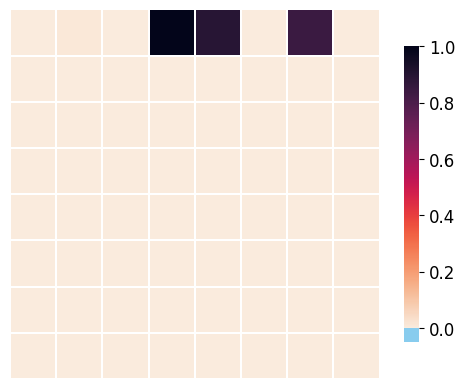

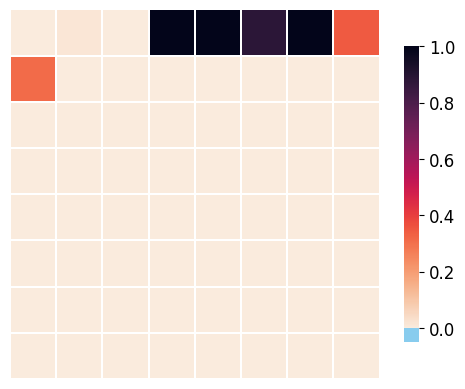

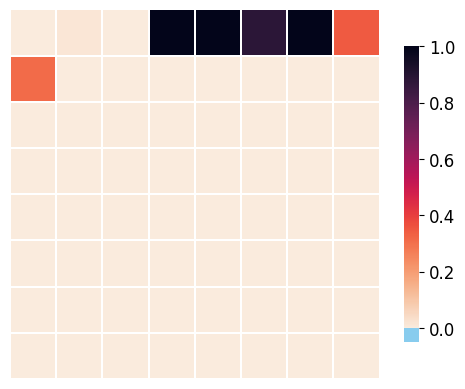

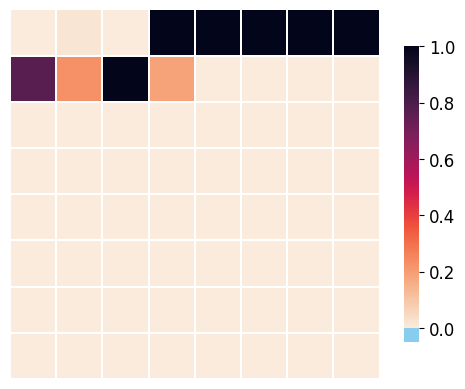

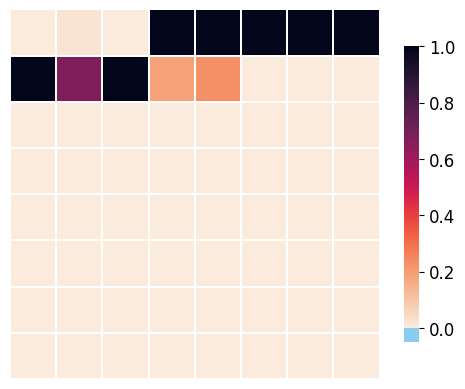

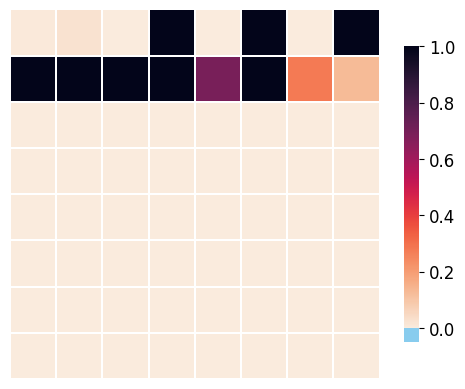

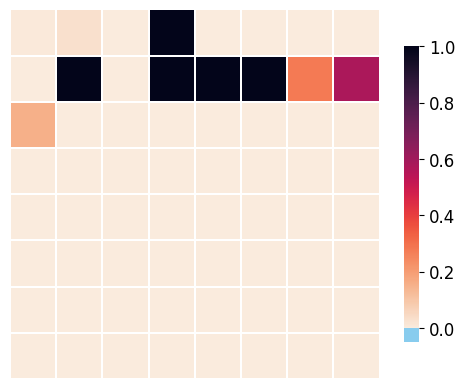

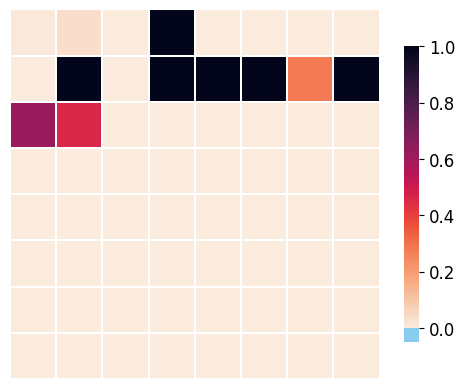

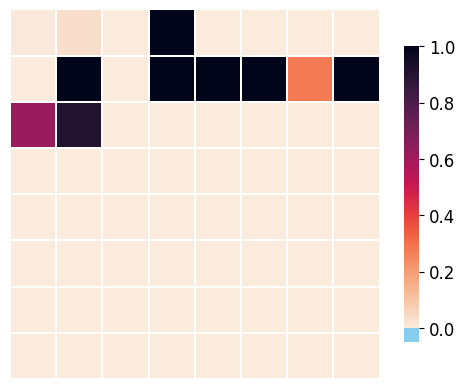

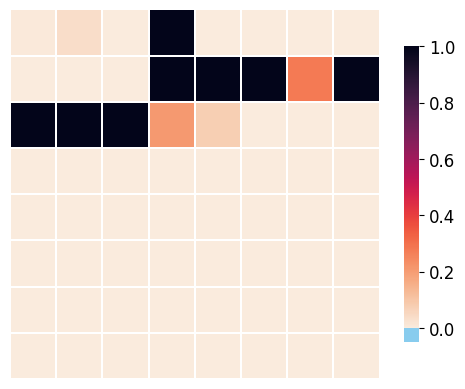

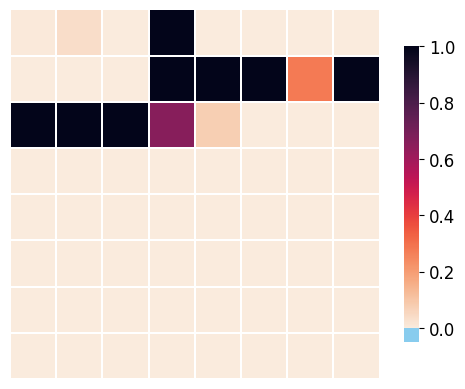

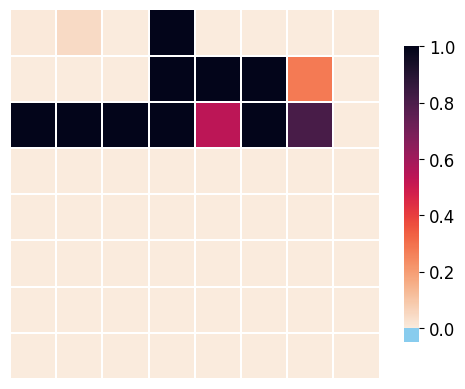

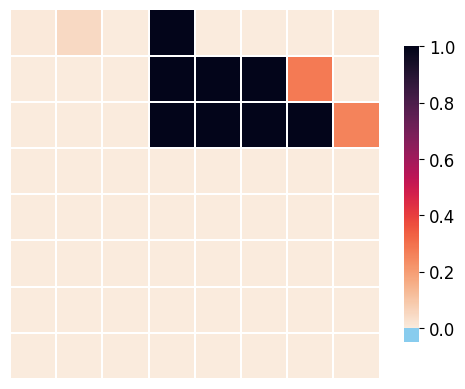

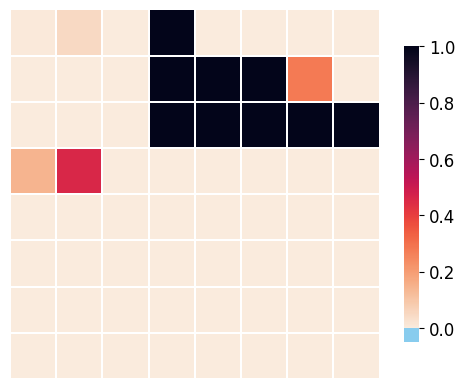

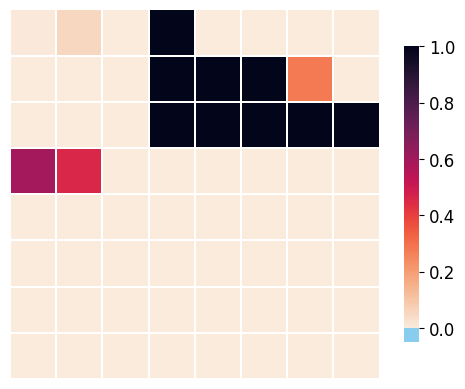

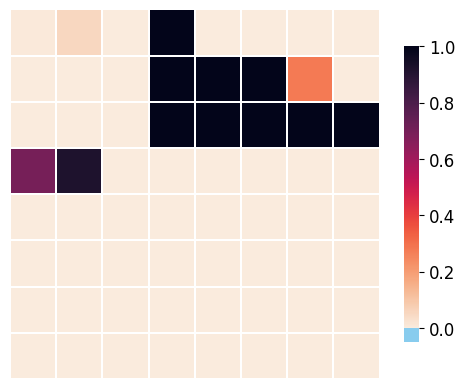

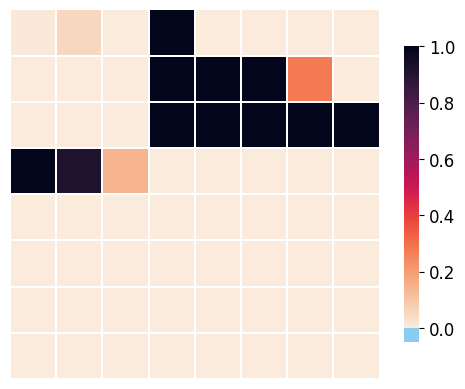

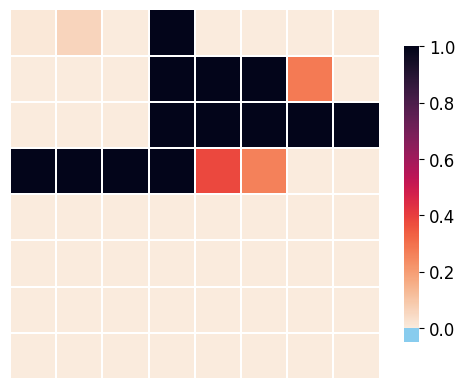

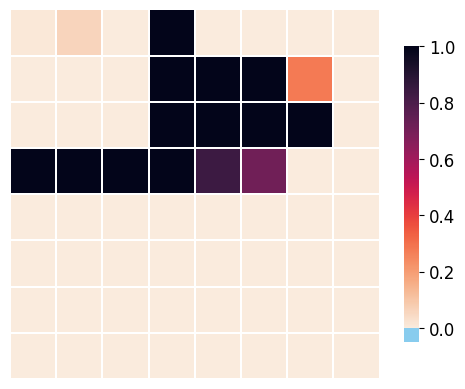

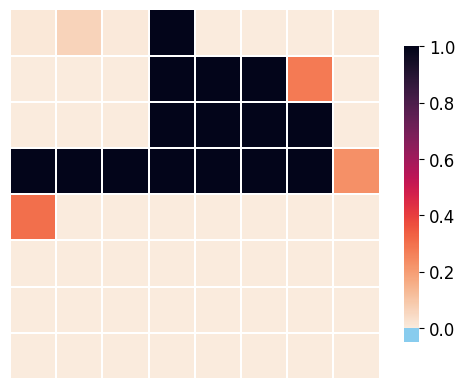

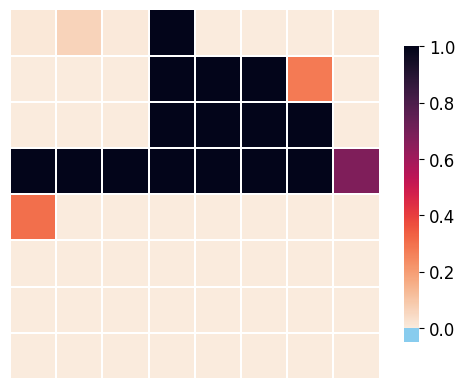

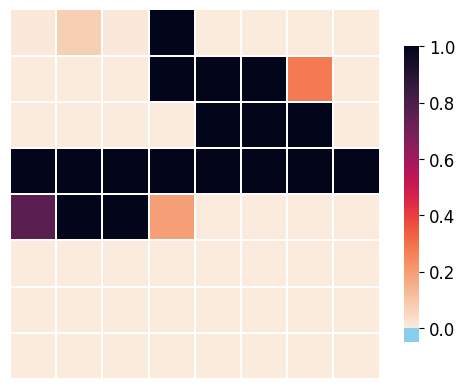

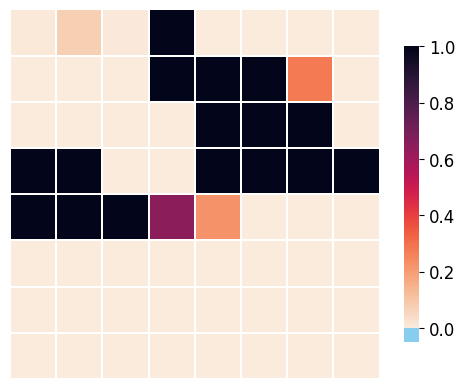

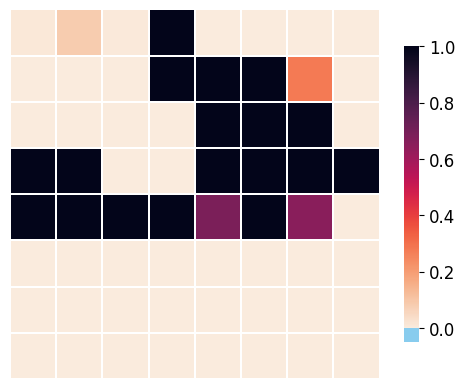

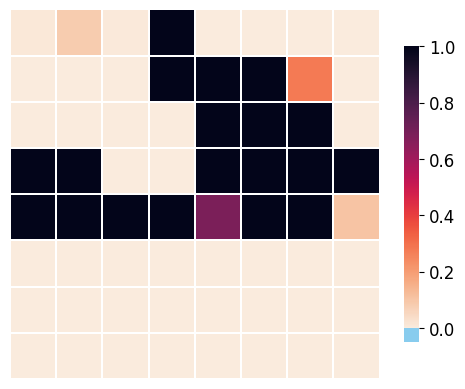

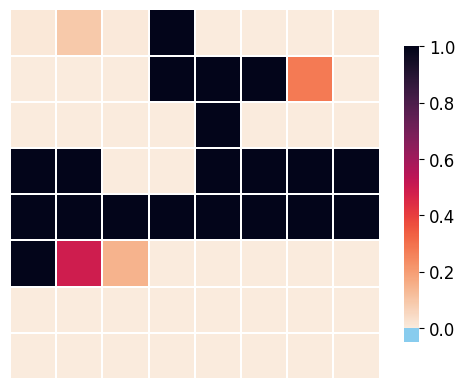

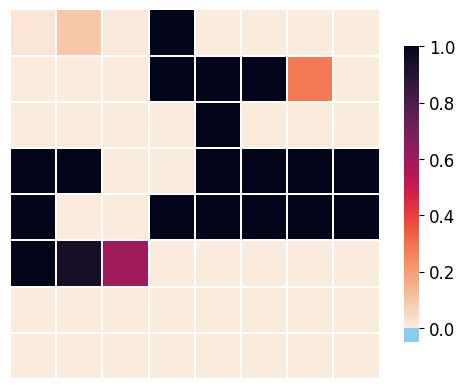

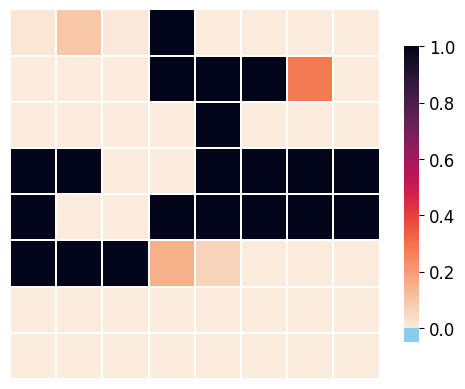

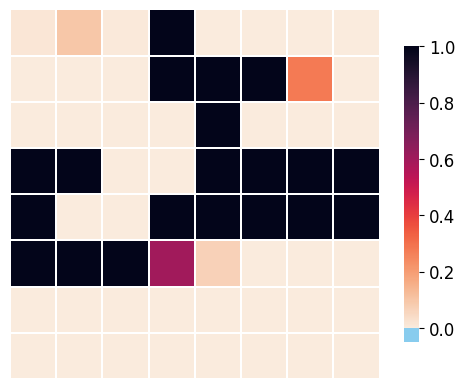

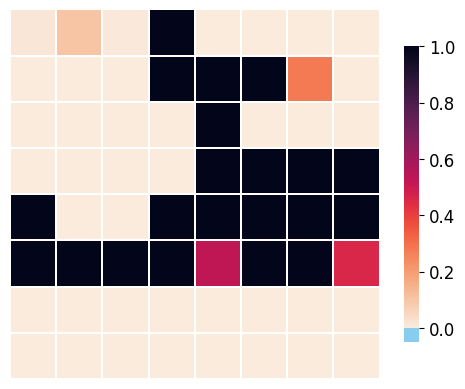

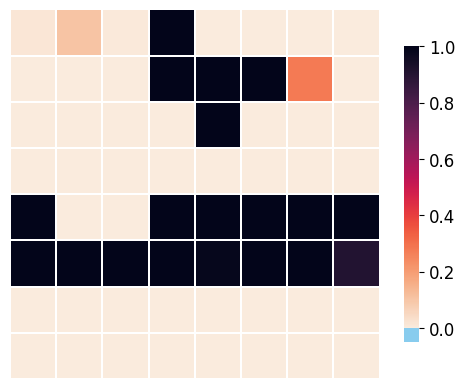

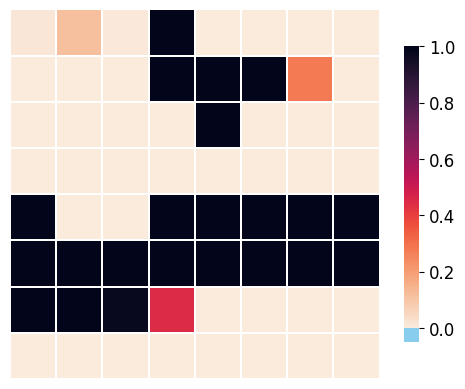

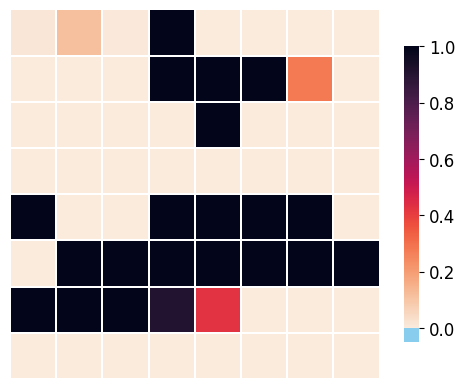

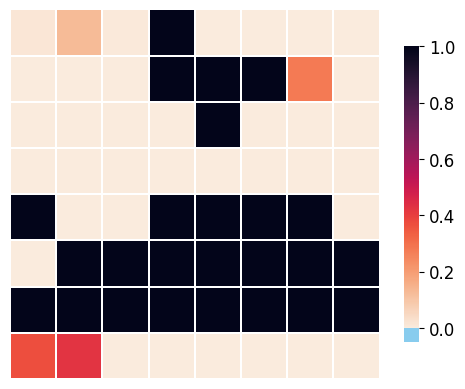

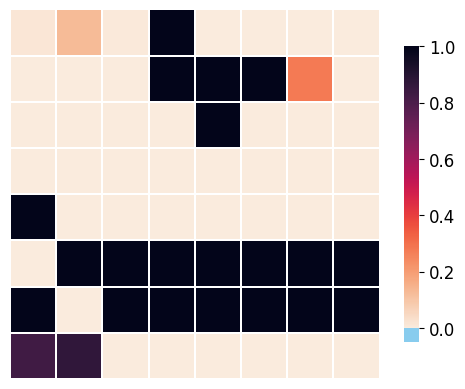

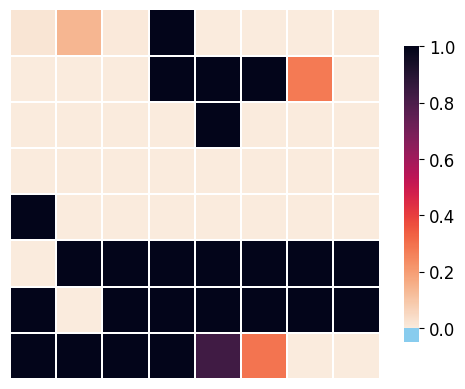

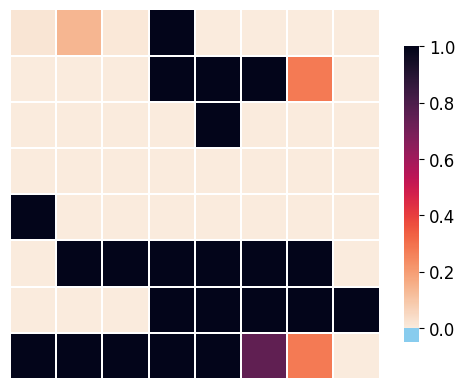

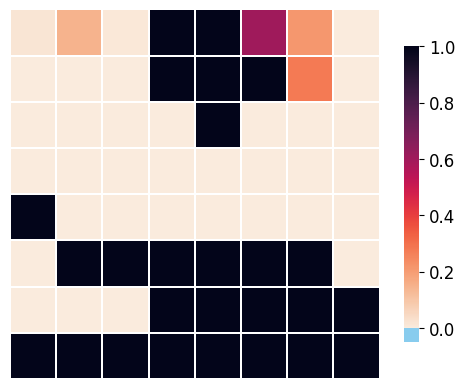

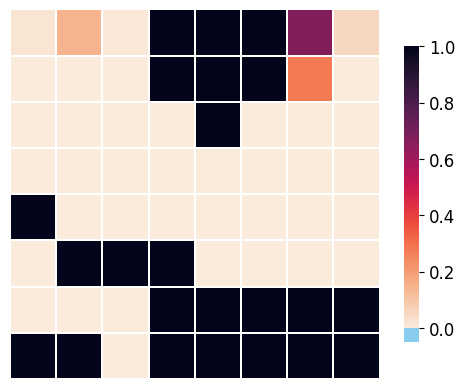

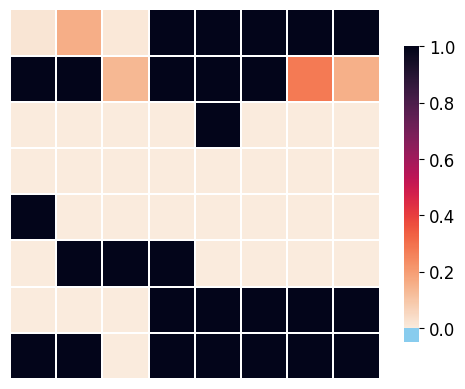

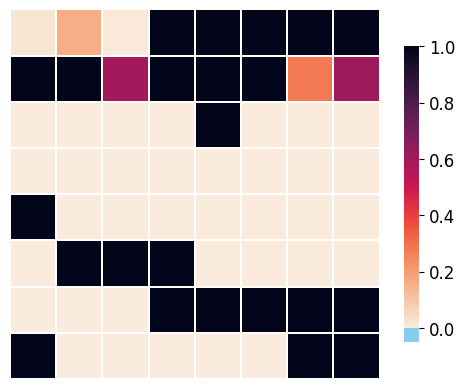

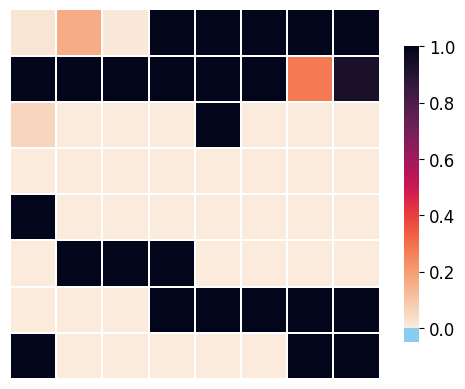

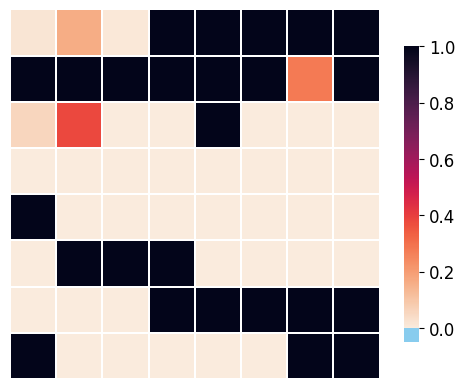

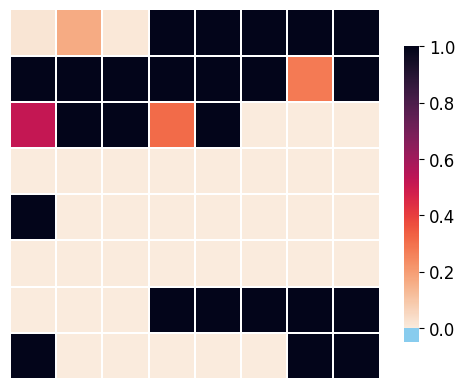

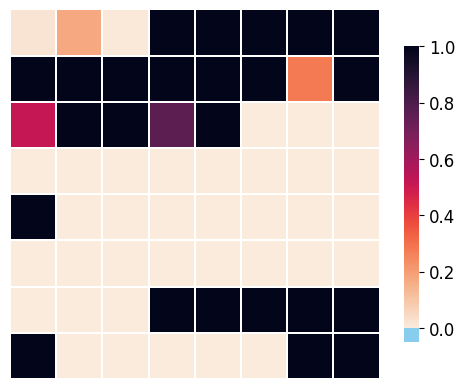

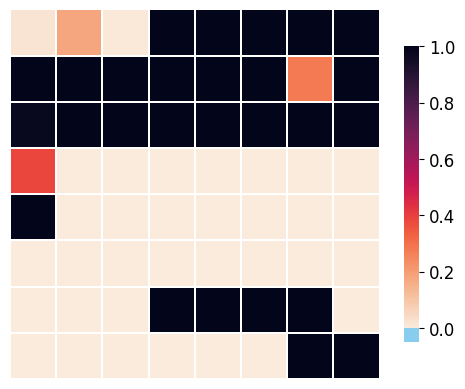

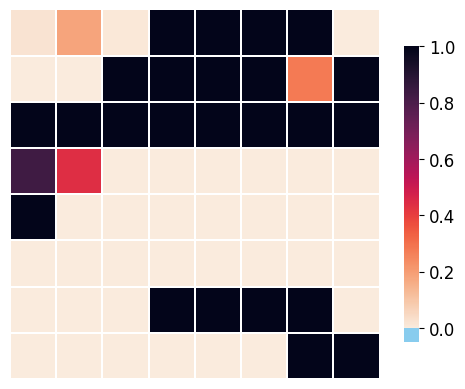

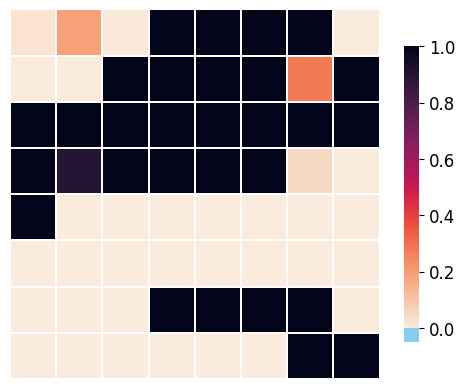

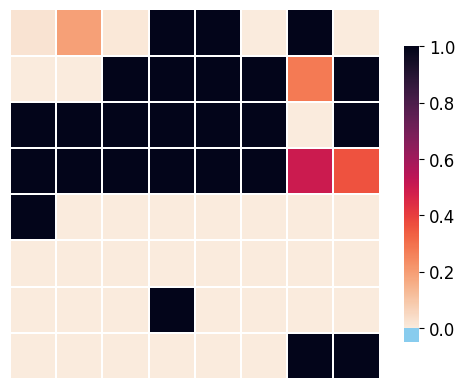

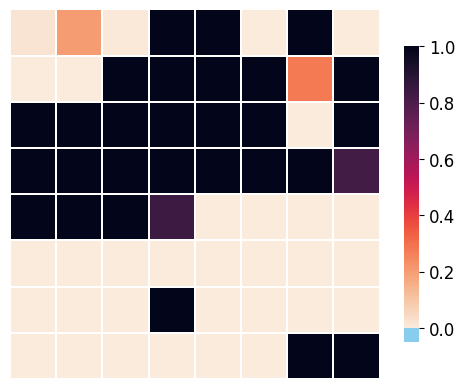

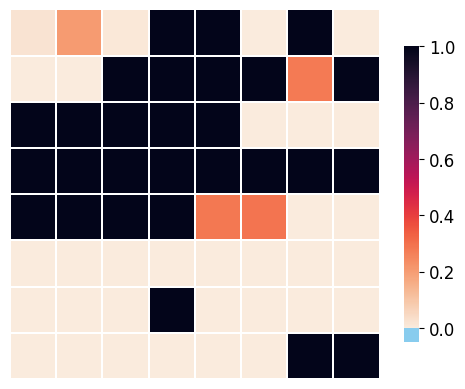

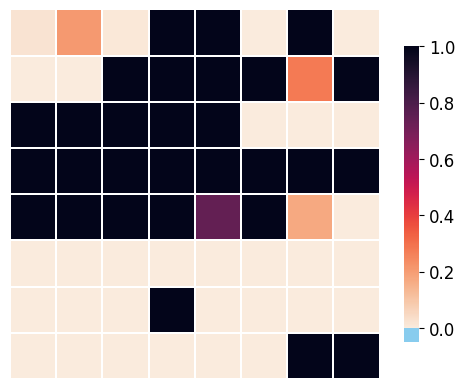

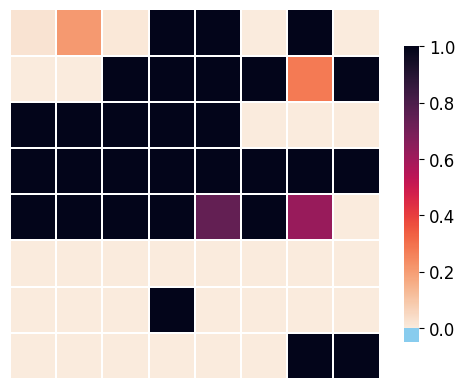

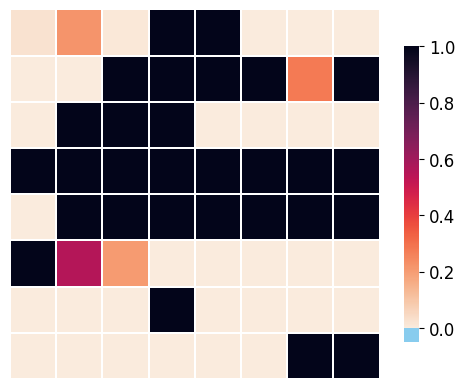

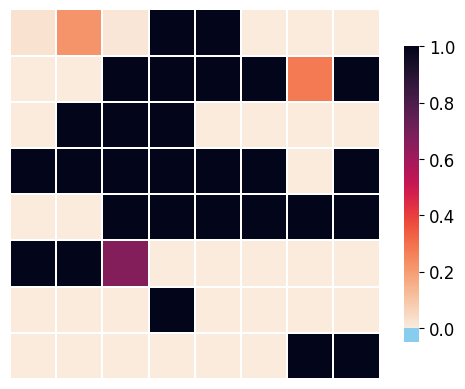

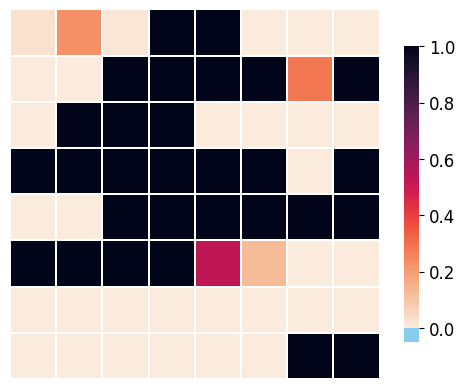

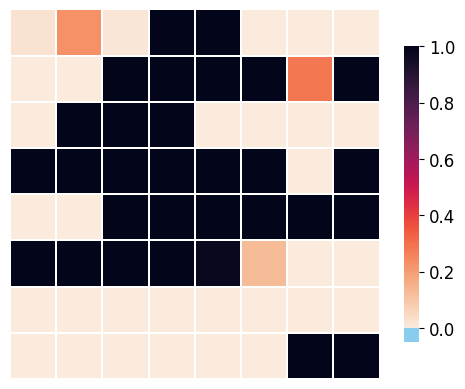

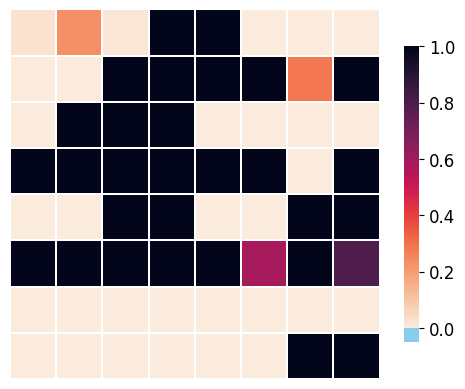

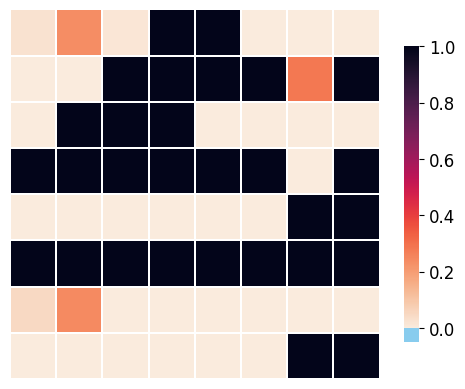

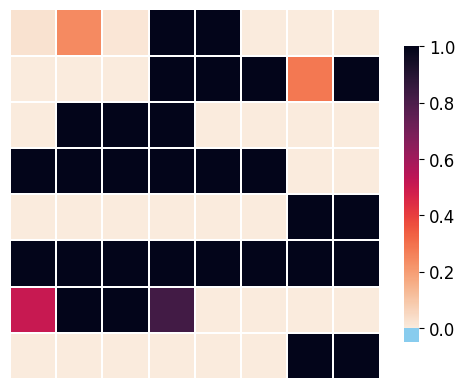

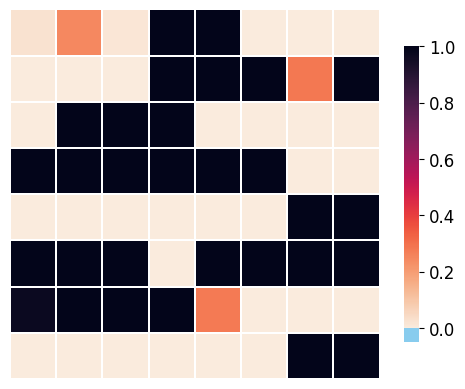

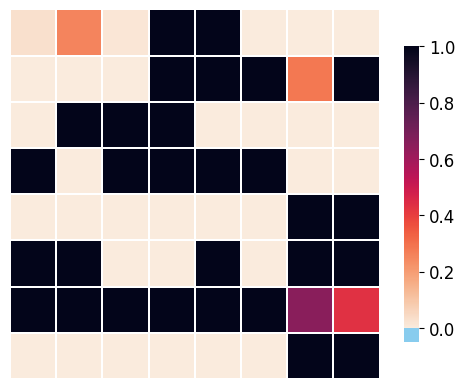

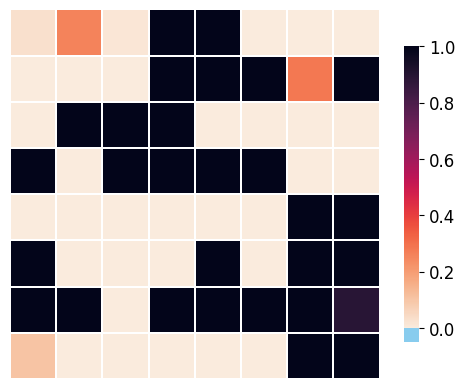

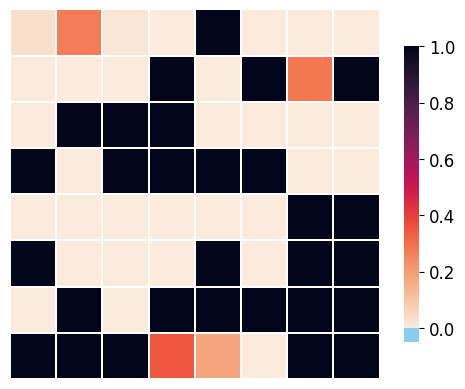

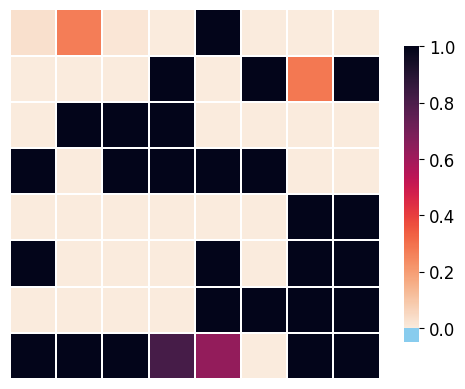

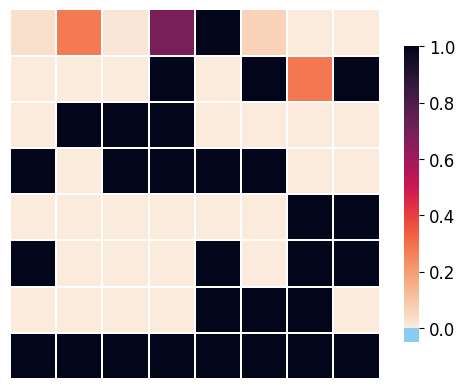

In [105]:
prev = False

for i in range(len(jobs)):
    if 'type' not in compactions[jobs[i]] or compactions[jobs[i]]['type'] != 'compaction':
        continue
    if prev:
        plt.figure()  
    prev = True
    plot(i, 'zones_snapshot_before')
    plt.figure()  
    plot(i, 'zones_snapshot_after')


In [439]:
compactions[jobs[5]]['zenfs_file_snapshot_before']

[{'filename': '/rocksdbtest/dbbench/000014.sst',
  'hint': 3,
  'size': 1122,
  'zones': {9: 1122}},
 {'filename': '/rocksdbtest/dbbench/000015.sst',
  'hint': 5,
  'size': 59800663,
  'zones': {5: 59800663}},
 {'filename': '/rocksdbtest/dbbench/000064.sst',
  'hint': 3,
  'size': 30234693,
  'zones': {29: 30234693}},
 {'filename': '/rocksdbtest/dbbench/000065.sst',
  'hint': 3,
  'size': 134832921,
  'zones': {29: 36704768, 10: 67108864, 11: 31019289}},
 {'filename': '/rocksdbtest/dbbench/000068.sst',
  'hint': 3,
  'size': 59790694,
  'zones': {6: 59790694}},
 {'filename': '/rocksdbtest/dbbench/000070.sst',
  'hint': 3,
  'size': 30287673,
  'zones': {14: 30287673}},
 {'filename': '/rocksdbtest/dbbench/000072.sst',
  'hint': 3,
  'size': 30255613,
  'zones': {15: 30255613}},
 {'filename': '/rocksdbtest/dbbench/000073.sst',
  'hint': 3,
  'size': 134832951,
  'zones': {13: 67108864, 18: 67108864, 33: 615223}},
 {'filename': '/rocksdbtest/dbbench/000075.sst',
  'hint': 3,
  'size': 303

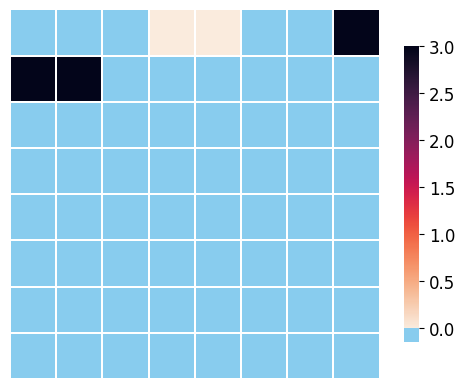

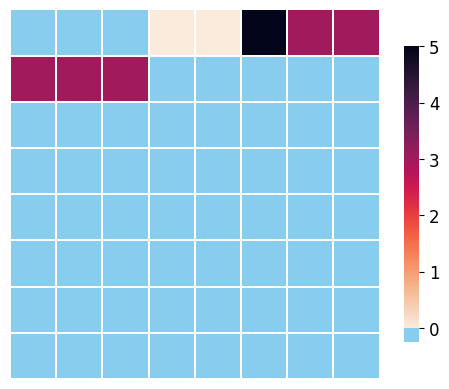

In [440]:


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = -1
    
    
for comp in compactions[jobs[0]]['zenfs_file_snapshot_before']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        write_data[math.floor(zone/8)][x_ind] = max(comp['hint'], write_data[math.floor(zone/8)][x_ind]) 
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)
plt.figure()


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = -1
for comp in compactions[jobs[0]]['zenfs_file_snapshot_after']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        write_data[math.floor(zone/8)][x_ind] = max(comp['hint'], write_data[math.floor(zone/8)][x_ind]) 
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

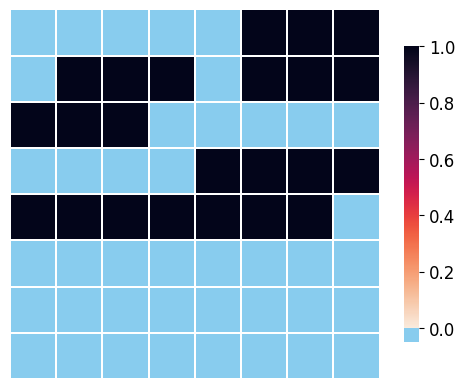

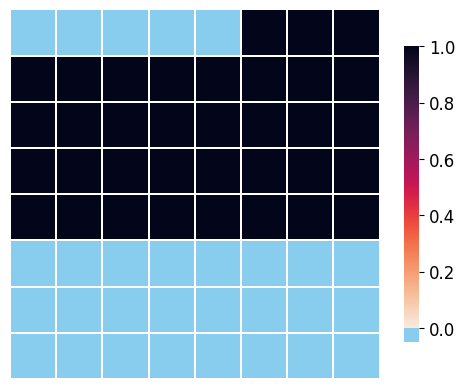

In [441]:


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = -1
    
    
for comp in compactions[jobs[5]]['zenfs_file_snapshot_before']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        write_data[math.floor(zone/8)][x_ind] = max(1, write_data[math.floor(zone/8)][x_ind]) if '.sst' in comp['filename'] else write_data[math.floor(zone/8)][x_ind]
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)
plt.figure()


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = -1
for comp in compactions[jobs[5]]['zenfs_file_snapshot_after']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        write_data[math.floor(zone/8)][x_ind] = max(1, write_data[math.floor(zone/8)][x_ind]) if '.sst' in comp['filename'] else write_data[math.floor(zone/8)][x_ind]
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

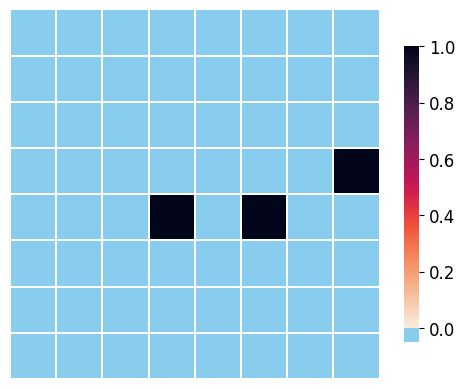

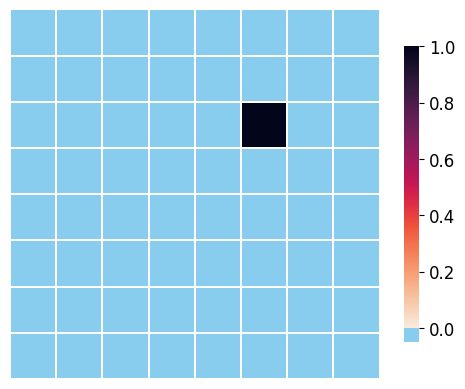

In [442]:


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = -1
    
    
for comp in compactions[jobs[5]]['zenfs_file_snapshot_before']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        if '.log' in comp['filename']:
            write_data[math.floor(zone/8)][x_ind] = 1

ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)
plt.figure()

write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = -1
for comp in compactions[jobs[5]]['zenfs_file_snapshot_after']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        if '.log' in comp['filename']:
            write_data[math.floor(zone/8)][x_ind] = 1
            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

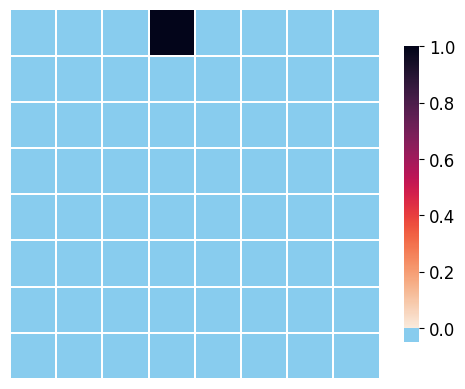

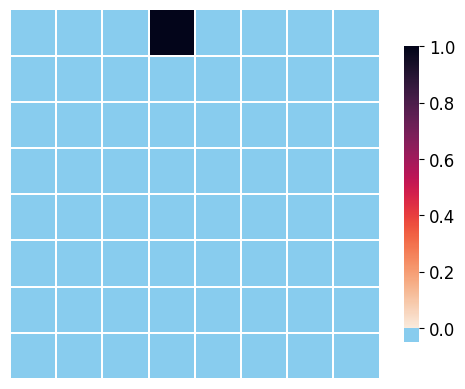

In [443]:


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = -1
    
    
for comp in compactions[jobs[5]]['zenfs_file_snapshot_before']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        if 'MAN' in comp['filename']:
            write_data[math.floor(zone/8)][x_ind] = 1

ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)
plt.figure()

write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = -1
for comp in compactions[jobs[5]]['zenfs_file_snapshot_after']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        if 'MAN' in comp['filename']:
            write_data[math.floor(zone/8)][x_ind] = 1
            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

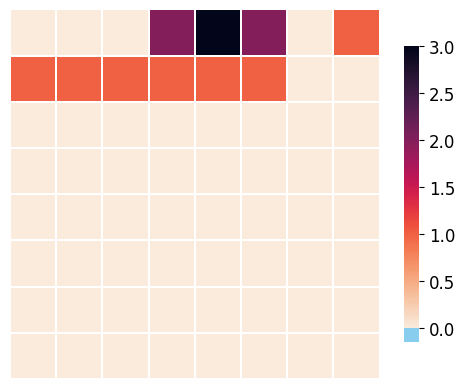

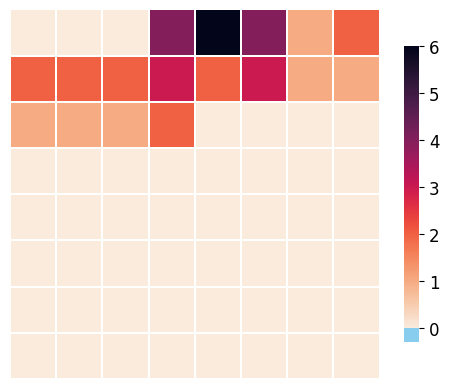

In [444]:


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = 0
    
    
for comp in compactions[jobs[2]]['zenfs_file_snapshot_before']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] + 1

ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)
plt.figure()


for comp in compactions[jobs[2]]['zenfs_file_snapshot_after']:
    for zone in comp['zones']:
        x_ind = zone % 8 
        write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] + 1

            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

{'filename': '/rocksdbtest/dbbench/000014.sst', 'hint': 3, 'size': 1122, 'zones': {9: 1122}}
{'filename': '/rocksdbtest/dbbench/000015.sst', 'hint': 5, 'size': 59800663, 'zones': {5: 59800663}}
{'filename': '/rocksdbtest/dbbench/000021.sst', 'hint': 3, 'size': 30270067, 'zones': {5: 7307776, 11: 22962291}}
{'filename': '/rocksdbtest/dbbench/000022.sst', 'hint': 3, 'size': 59674757, 'zones': {12: 59674757}}
{'filename': '/rocksdbtest/dbbench/000024.sst', 'hint': 3, 'size': 30288686, 'zones': {7: 30288686}}
{'filename': '/rocksdbtest/dbbench/000025.log', 'hint': 2, 'size': 5942224, 'zones': {10: 5942224}}
{'filename': '/rocksdbtest/dbbench/000026.sst', 'hint': 3, 'size': 30272147, 'zones': {8: 30272147}}
{'filename': '/rocksdbtest/dbbench/000027.sst', 'hint': 3, 'size': 3182, 'zones': {13: 3182}}
{'filename': '/rocksdbtest/dbbench/000028.log', 'hint': 2, 'size': 0, 'zones': {}}
{'filename': '/rocksdbtest/dbbench/000029.sst', 'hint': 3, 'size': 0, 'zones': {}}
{'filename': '/rocksdbtest/d

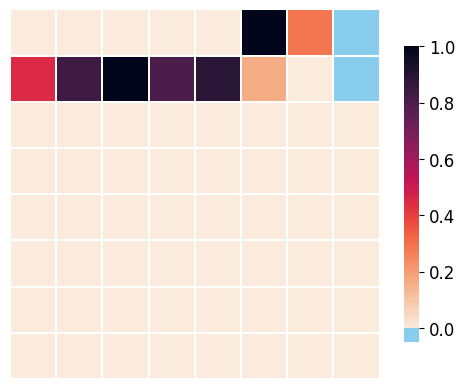

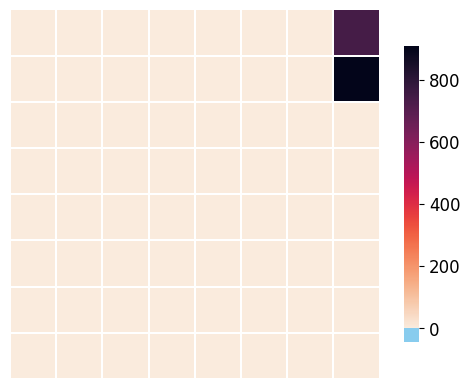

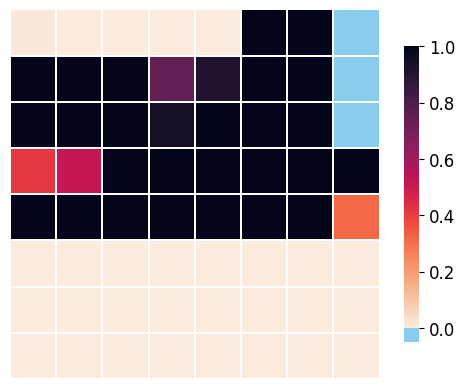

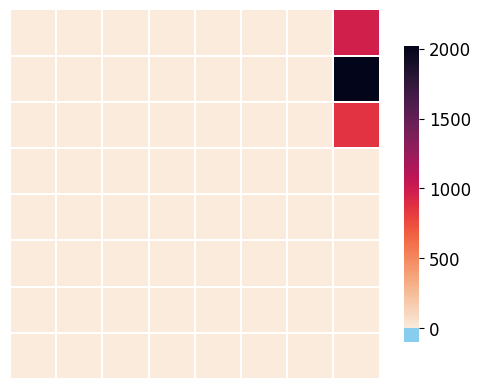

In [445]:
write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = 0

i = 0 
for zone in compactions[jobs[2]]['zones_snapshot_before']:
    x_ind = i % 8 
    write_data[math.floor(i/8)][x_ind] = cap if zone['state'] == 'FULL' else 0 if zone['state'] == 'EMPTY' else zone['wp'] 
    i = i + 1

for comp in compactions[jobs[2]]['zenfs_file_snapshot_before']:
    for zone, val in comp['zones'].items():
        write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] - val
        
for i in range(64):
    write_data[i % 8][int(i/8)] = write_data[i % 8][int(i/8)] / cap
            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

plt.figure()


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = 0


for comp in compactions[jobs[2]]['zenfs_file_snapshot_before']:
    print(comp)
    for zone, val in comp['zones'].items():
        write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] + val
        
for i in range(64):
    write_data[i % 8][int(i/8)] = write_data[i % 8][int(i/8)] / cap
            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

plt.figure()

write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = 0

i = 0 
for zone in compactions[jobs[5]]['zones_snapshot_after']:
    x_ind = i % 8 
    write_data[math.floor(i/8)][x_ind] = cap if zone['state'] == 'FULL' else 0 if zone['state'] == 'EMPTY' else zone['wp'] 
    i = i + 1

for comp in compactions[jobs[2]]['zenfs_file_snapshot_after']:
    print(comp)
    for zone, val in comp['zones'].items():
        write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] - val
        
for i in range(64):
    write_data[i % 8][int(i/8)] = write_data[i % 8][int(i/8)] / cap
            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

plt.figure()


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = 0


for comp in compactions[jobs[2]]['zenfs_file_snapshot_after']:
    print(comp)
    for zone, val in comp['zones'].items():
        write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] + val
        
for i in range(64):
    write_data[i % 8][int(i/8)] = write_data[i % 8][int(i/8)] / cap
            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

In [128]:
write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = 0

i = 0 
for zone in compactions[jobs[0]]['zones_snapshot_before']:
    x_ind = i % 8 
    write_data[math.floor(i/8)][x_ind] = cap * 512 if zone['state'] == 'FULL' else 0 if zone['state'] == 'EMPTY' else zone['wp'] * 512 
    i = i + 1

for comp in compactions[jobs[0]]['zenfs_file_snapshot_before']:
    for zone, val in comp['zones'].items():
        write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] - val
        
for i in range(64):
    write_data[i % 8][int(i/8)] = write_data[i % 8][int(i/8)] / (cap * 512)
            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

plt.figure()


write_data = np.zeros(shape=(8, 8))
for i in range(64):
    write_data[i%8][int(i/8)] = 0


for comp in compactions[jobs[0]]['zenfs_file_snapshot_before']:
    print(comp)
    for zone, val in comp['zones'].items():
        x_ind = zone % 8 
        write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] + val
        print(x_ind, zone/8, write_data[math.floor(zone/8)][x_ind] )
        
for i in range(64):
    write_data[i % 8][int(i/8)] = write_data[i % 8][int(i/8)] / (cap * 512)
            
ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
                     cmap=cmap, mask=(write_data == None), yticklabels=False, 
                     clip_on=False, 
                     cbar_kws={'shrink': 0.8, 
                               'extend': 'min', 
                               'extendrect': True}, 
                     square=True, cbar=True, vmin=0)

plt.figure()

# write_data = np.zeros(shape=(8, 8))
# for i in range(64):
#     write_data[i%8][int(i/8)] = 0

# i = 0 
# for zone in compactions[jobs[0]]['zones_snapshot_after']:
#     x_ind = i % 8 
#     write_data[math.floor(i/8)][x_ind] = cap if zone['state'] == 'FULL' else 0 if zone['state'] == 'EMPTY' else zone['wp'] 
#     i = i + 1

# for comp in compactions[jobs[0]]['zenfs_file_snapshot_after']:
#     print(comp)
#     for zone, val in comp['zones'].items():
#         write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] - val
        
# for i in range(64):
#     write_data[i % 8][int(i/8)] = write_data[i % 8][int(i/8)] / cap
            
# ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
#                      cmap=cmap, mask=(write_data == None), yticklabels=False, 
#                      clip_on=False, 
#                      cbar_kws={'shrink': 0.8, 
#                                'extend': 'min', 
#                                'extendrect': True}, 
#                      square=True, cbar=True, vmin=0)

# plt.figure()


# write_data = np.zeros(shape=(8, 8))
# for i in range(64):
#     write_data[i%8][int(i/8)] = 0


# for comp in compactions[jobs[0]]['zenfs_file_snapshot_after']:
#     print(comp)
#     for zone, val in comp['zones'].items():
#         write_data[math.floor(zone/8)][x_ind] = write_data[math.floor(zone/8)][x_ind] + val
        
# for i in range(64):
#     write_data[i % 8][int(i/8)] = write_data[i % 8][int(i/8)] / cap
            
# ax = sns.heatmap(write_data, linewidth=0.1, xticklabels=False, 
#                      cmap=cmap, mask=(write_data == None), yticklabels=False, 
#                      clip_on=False, 
#                      cbar_kws={'shrink': 0.8, 
#                                'extend': 'min', 
#                                'extendrect': True}, 
#                      square=True, cbar=True, vmin=0)
print(cap)

NameError: name 'cmap' is not defined

In [100]:
max_bytes_base = 256 * 1048576
max_bytes_base = 1024 * 1024

for job in jobs:
    if 'type' not in compactions[job]:
        continue
    if compactions[job]['type'] != 'compaction':
        continue
    their_score = [0] * len(compactions[job]['scores'])
    for i in range(len(their_score)):
        their_score[compactions[job]['scores_levels'][i]] = compactions[job]['scores'][i]
    print("their score", their_score)
    # print(compactions[jobs[0]]['zenfs_file_snapshot_before'])
    ddd = compactions[job]['f2fs_file_snapshot_before']
    score = []
    for i in range(5):
        score.append(0)
    score[0] = [0,0]
    for dddd in ddd:
        level = -1
        if '.sst' not in dddd['filename']:
            continue
        filename_id = str(int(dddd['filename'].split('/')[-1].split('.sst')[0]))
        skip = True
        for comp in compactions[job]['file_snapshot']:
            if comp['id'] == filename_id:
                skip = False
        if (skip):
            continue
        j = len(table_levels[dddd['filename']]) - 1
        while j >= 0:
            if table_levels[dddd['filename']][j][0] <= job:
                level = table_levels[dddd['filename']][j][1]
                break
            j = j - 1

    #     print(dddd['filename'], level)

        if level > 0:
            score[level] = score[level] + dddd['size']
        if level == 0:
            score[level][0] = score[level][0] + dddd['size'] 
            score[level][1] = score[level][1] + 1

    score[0] = max(score[0][1] / 4, score[0][0] / max_bytes_base)

    for i in range(len(score)-1):
        if i == 0:
            score[i+1] =  score[i+1] / max_bytes_base
    #         print(max_bytes_base)
        else:
            #print(i, i*4, max_bytes_base, (4 ** (i-1)) * max_bytes_base)
    #         print(score[i+1],    (4 ** (i)) * max_bytes_base)            
            score[i+1] =  score[i+1] / ((4 ** (i)) * max_bytes_base)
    print("our score", score)
        
    dif = [0] * len(compactions[job]['scores'])
    for i in range(len(dif)):
        dif[i] = abs(score[i] - their_score[i])
    print("diff", dif)

their score [0, 0, 0, 1.79684]
our score [0.0, 0.0, 0.0, 1.718505859375, 0.0]
diff [0.0, 0.0, 0.0, 0.07833414062499999]
their score [0, 0, 0, 1.79566]
our score [0.0, 0.0, 0.0, 1.764404296875, 0.0]
diff [0.0, 0.0, 0.0, 0.031255703125000034]
their score [0, 0, 0, 3.52933]
our score [0.0, 0.0, 0.0, 3.4189453125, 0.0]
diff [0.0, 0.0, 0.0, 0.11038468749999986]
their score [57.443, 0, 0, 0]
our score [55.55078125, 0.0, 0.0, 0.0, 0.0]
diff [1.8922187499999978, 0.0, 0.0, 0.0]
their score [0, 28.7442, 14.1111, 0]
our score [0.0, 26.89453125, 13.5947265625, 0.0, 0.0]
diff [0.0, 1.8496687499999993, 0.5163734375000004, 0.0]
their score [0, 28.7304, 20.8093, 0]
our score [0.0, 28.0703125, 20.3017578125, 0.0, 0.0]
diff [0.0, 0.6600874999999995, 0.5075421875000004, 0.0]
their score [57.4957, 0, 27.2868, 0]
our score [56.0078125, 0.0, 26.4619140625, 0.0, 0.0]
diff [1.4878874999999994, 0.0, 0.8248859374999995, 0.0]
their score [28.762, 56.4508, 27.2868, 0]
our score [28.73046875, 53.9921875, 26.461914

In [38]:
table_levels

{'/mnt/f2fs/db0/000011.sst': [(2, 0), (3, 1), (4, 2), (5, 3), (6, 4)],
 '/mnt/f2fs/db0/000013.sst': [(7, 0), (8, 1), (9, 2), (10, 3)],
 '/mnt/f2fs/db0/000015.sst': [(12, 0)],
 '/mnt/f2fs/db0/000017.sst': [(13, 0)],
 '/mnt/f2fs/db0/000018.sst': [(14, 0)],
 '/mnt/f2fs/db0/000020.sst': [(15, 0)],
 '/mnt/f2fs/db0/000022.sst': [(16, 0)],
 '/mnt/f2fs/db0/000024.sst': [(17, 0)],
 '/mnt/f2fs/db0/000026.sst': [(18, 0)],
 '/mnt/f2fs/db0/000028.sst': [(19, 0)],
 '/mnt/f2fs/db0/000030.sst': [(20, 0)],
 '/mnt/f2fs/db0/000032.sst': [(21, 0)],
 '/mnt/f2fs/db0/000034.sst': [(22, 0)],
 '/mnt/f2fs/db0/000036.sst': [(23, 0)],
 '/mnt/f2fs/db0/000038.sst': [(24, 0)],
 '/mnt/f2fs/db0/000040.sst': [(25, 0)],
 '/mnt/f2fs/db0/000042.sst': [(26, 0)],
 '/mnt/f2fs/db0/000044.sst': [(27, 0)],
 '/mnt/f2fs/db0/000046.sst': [(28, 0)],
 '/mnt/f2fs/db0/000048.sst': [(29, 0)],
 '/mnt/f2fs/db0/000050.sst': [(30, 0)],
 '/mnt/f2fs/db0/000052.sst': [(31, 0)],
 '/mnt/f2fs/db0/000054.sst': [(32, 0)],
 '/mnt/f2fs/db0/000057.ss

In [87]:
print(compactions[64])

{'type': 'compaction', 'scores': [108.318, 86.2272, 27.1024, 0.0135307], 'scores_levels': [2, 0, 3, 1], 'high_score': 108.318, 'level': 2, 'from': [111], 'into': [60], 'file_snapshot': [{'level': 0, 'size': '30128337', 'id': '117', 'compacting': '0'}, {'level': 0, 'size': '30123907', 'id': '110', 'compacting': '0'}, {'level': 0, 'size': '30163558', 'id': '108', 'compacting': '0'}, {'level': 1, 'size': '14188', 'id': '115', 'compacting': '0'}, {'level': 2, 'size': '134832749', 'id': '111', 'compacting': '1'}, {'level': 2, 'size': '134832746', 'id': '112', 'compacting': '0'}, {'level': 2, 'size': '134723581', 'id': '113', 'compacting': '0'}, {'level': 2, 'size': '49927998', 'id': '114', 'compacting': '0'}, {'level': 3, 'size': '134832794', 'id': '60', 'compacting': '1'}, {'level': 3, 'size': '134832812', 'id': '61', 'compacting': '0'}, {'level': 3, 'size': '134832809', 'id': '62', 'compacting': '0'}, {'level': 3, 'size': '50204793', 'id': '65', 'compacting': '0'}], 'creation': [], 'delet

In [85]:
print(compactions[64]['file_snapshot'])

[{'level': 0, 'size': '30128337', 'id': '117', 'compacting': '0'}, {'level': 0, 'size': '30123907', 'id': '110', 'compacting': '0'}, {'level': 0, 'size': '30163558', 'id': '108', 'compacting': '0'}, {'level': 1, 'size': '14188', 'id': '115', 'compacting': '0'}, {'level': 2, 'size': '134832749', 'id': '111', 'compacting': '1'}, {'level': 2, 'size': '134832746', 'id': '112', 'compacting': '0'}, {'level': 2, 'size': '134723581', 'id': '113', 'compacting': '0'}, {'level': 2, 'size': '49927998', 'id': '114', 'compacting': '0'}, {'level': 3, 'size': '134832794', 'id': '60', 'compacting': '1'}, {'level': 3, 'size': '134832812', 'id': '61', 'compacting': '0'}, {'level': 3, 'size': '134832809', 'id': '62', 'compacting': '0'}, {'level': 3, 'size': '50204793', 'id': '65', 'compacting': '0'}]


In [112]:
print(jobs[0])
for f in compactions[jobs[0]]['zenfs_file_snapshot_before']:
    print(f['filename'])

12
/rocksdbtest/dbbench/000011.sst
/rocksdbtest/dbbench/000012.log
/rocksdbtest/dbbench/000013.sst
/rocksdbtest/dbbench/000014.sst
/rocksdbtest/dbbench/CURRENT
/rocksdbtest/dbbench/IDENTITY
/rocksdbtest/dbbench/MANIFEST-000005
/rocksdbtest/dbbench/OPTIONS-000007
/rocksdbtest/dbbench/OPTIONS-000009


In [101]:
print('trivial:')
for job in jobs:
    if 'trivial_move' not in compactions[job]['type']:
        continue
    level = compactions[job]['level']
    print('    ', job, f'L{level}->L{level+1}:', compactions[job]['creation'], '->', compactions[job]['creation'])
    rr = [x[1] for x in compactions[job]['past_resets']]
    print('     R:', rr)   

print('flush:')
for job in jobs:
    if 'flush' not in compactions[job]['type']:
        continue
    print('    ', job, compactions[job]['creation'])
    rr = [x[1] for x in compactions[job]['past_resets']]
    print('     R:', rr)


print('compaction:')
for job in jobs:
    if 'compaction' not in compactions[job]['type']:
        continue
    level = compactions[job]['level']
    print('    ', job, f'L{level}->L{level+1}:', compactions[job]['from'],'|',  compactions[job]['into'], '->', compactions[job]['creation'])
    print('     D:', compactions[job]['deletion'])
    rr = [x[1] for x in compactions[job]['past_resets']]
    print('     R:', rr)


trivial:
     3 L0->L1: [11] -> [11]
     R: []
     4 L1->L2: [11] -> [11]
     R: []
     5 L2->L3: [11] -> [11]
     R: []
     6 L3->L4: [11] -> [11]
     R: []
     8 L0->L1: [13] -> [13]
     R: []
     9 L1->L2: [13] -> [13]
     R: []
     10 L2->L3: [13] -> [13]
     R: []
     14 L0->L1: [15] -> [15]
     R: []
     15 L1->L2: [15] -> [15]
     R: []
     16 L2->L3: [15] -> [15]
     R: []
     20 L0->L1: [20] -> [20]
     R: []
     21 L1->L2: [20] -> [20]
     R: []
     22 L2->L3: [20] -> [20]
     R: []
     28 L1->L2: [33, 34] -> [33, 34]
     R: []
     29 L0->L1: [31] -> [31]
     R: []
     32 L0->L1: [35] -> [35]
     R: []
     83 L2->L3: [111, 137, 138, 140] -> [111, 137, 138, 140]
     R: []
     87 L1->L2: [144] -> [144]
     R: []
     88 L2->L3: [127, 124] -> [127, 124]
     R: []
     89 L1->L2: [145, 147] -> [145, 147]
     R: []
flush:
     2 ['11']
     R: []
     7 ['13']
     R: []
     11 ['15']
     R: []
     13 ['18']
     R: []
     18 ['20']
     R:

In [135]:
print(flushes)

for flush in flushes:
    table_file_id = flush[1]
    table_file_preamble = '000000'[:6-len(flush[1])]
    table_file_name = f'{db_path}{table_file_preamble}{table_file_id}.sst'
    job = flush[0]
    j = 0
    
    
    print()

[(2, '11'), (6, '13'), (12, '15'), (13, '16'), (14, '18'), (15, '20'), (16, '22'), (17, '24'), (18, '26'), (19, '28'), (20, '30'), (21, '32'), (22, '34'), (23, '36'), (24, '38'), (25, '40'), (26, '42'), (27, '44'), (28, '46'), (29, '48'), (30, '50'), (31, '52'), (32, '55'), (33, '57'), (35, '59'), (36, '64'), (40, '69'), (41, '70'), (42, '72'), (43, '74'), (44, '76'), (45, '78'), (46, '80'), (47, '82'), (48, '84'), (49, '86'), (50, '88'), (51, '90'), (52, '92'), (53, '94'), (54, '96'), (55, '98'), (56, '100'), (57, '102'), (58, '106'), (60, '108'), (61, '110'), (62, '117'), (65, '120'), (66, '121'), (67, '123'), (68, '125'), (69, '127'), (70, '129'), (71, '131'), (72, '133'), (73, '135')]
{'type': 'flush', 'creation': ['11']}
{'type': 'flush', 'creation': ['11']}

{'type': 'flush', 'creation': ['13']}
{'type': 'flush', 'creation': ['13']}

{'type': 'flush', 'creation': ['15']}
{'type': 'flush', 'creation': ['15']}

{'type': 'flush', 'creation': ['16']}
{'type': 'flush', 'creation': ['1

In [77]:
print(trivial_compactions)

[(3, 11, 1), (4, 11, 2), (5, 11, 3), (7, 11, 4), (8, 13, 1), (9, 13, 2), (10, 13, 3), (37, 60, 2), (37, 61, 2), (37, 62, 2), (37, 65, 2), (38, 60, 3), (38, 61, 3), (38, 62, 3), (38, 65, 3), (63, 111, 2), (63, 112, 2), (63, 113, 2), (63, 114, 2)]


In [62]:
print(compactions[64])

{'type': 'compaction', 'scores': [108.318, 86.2261, 27.1025, 0.0135307], 'scores_levels': [2, 0, 3, 1], 'high_score': 108.318, 'level': 2, 'from': [111], 'into': [60], 'file_snapshot': [{'level': 0, 'size': '30128307', 'id': '117', 'compacting': '0'}, {'level': 0, 'size': '30122752', 'id': '110', 'compacting': '0'}, {'level': 0, 'size': '30163538', 'id': '108', 'compacting': '0'}, {'level': 1, 'size': '14188', 'id': '115', 'compacting': '0'}, {'level': 2, 'size': '134832781', 'id': '111', 'compacting': '1'}, {'level': 2, 'size': '134832838', 'id': '112', 'compacting': '0'}, {'level': 2, 'size': '134724666', 'id': '113', 'compacting': '0'}, {'level': 2, 'size': '49927998', 'id': '114', 'compacting': '0'}, {'level': 3, 'size': '134832794', 'id': '60', 'compacting': '1'}, {'level': 3, 'size': '134832812', 'id': '61', 'compacting': '0'}, {'level': 3, 'size': '134832819', 'id': '62', 'compacting': '0'}, {'level': 3, 'size': '50205954', 'id': '65', 'compacting': '0'}], 'creation': [], 'delet

In [60]:
print(compactions[34]['f2fs_file_snapshot_after'])

[{'filename': '/mnt/f2fs/db0/000015.sst', 'hint': [(1, 'CURSEG_WARM_NODE', 1024)], 'size': 1024, 'zones': [1]}, {'filename': '/mnt/f2fs/db0/IDENTITY', 'hint': [(1, 'CURSEG_WARM_NODE', 0)], 'size': 0, 'zones': [1]}, {'filename': '/mnt/f2fs/db0/CURRENT', 'hint': [(1, 'CURSEG_WARM_NODE', 0)], 'size': 0, 'zones': [1]}, {'filename': '/mnt/f2fs/db0/OPTIONS-000007', 'hint': [(3, 'CURSEG_HOT_DATA', 12288)], 'size': 12288, 'zones': [3]}, {'filename': '/mnt/f2fs/db0/OPTIONS-000009', 'hint': [(3, 'CURSEG_HOT_DATA', 12288)], 'size': 12288, 'zones': [3]}, {'filename': '/mnt/f2fs/db0/000016.sst', 'hint': [(4, 'CURSEG_WARM_DATA', 6291456), (7, 'CURSEG_WARM_DATA', 23068672), (7, 'CURSEG_WARM_DATA', 241664)], 'size': 29601792, 'zones': [4, 7]}, {'filename': '/mnt/f2fs/db0/000053.sst', 'hint': [(5, 'CURSEG_COLD_DATA', 58720256), (5, 'CURSEG_COLD_DATA', 532480), (24, 'CURSEG_HOT_DATA', 4096)], 'size': 59256832, 'zones': [5, 24]}, {'filename': '/mnt/f2fs/db0/000018.sst', 'hint': [(7, 'CURSEG_WARM_DATA', 2

In [98]:
print(compactions[64]['f2fs_file_snapshot_after'])

[{'filename': '/mnt/f2fs/db0/000016.sst', 'hint': [(4, 'CURSEG_WARM_NODE')], 'size': 1024, 'zones': [4]}, {'filename': '/mnt/f2fs/db0/IDENTITY', 'hint': [(4, 'CURSEG_WARM_NODE')], 'size': 0, 'zones': [4]}, {'filename': '/mnt/f2fs/db0/CURRENT', 'hint': [(4, 'CURSEG_WARM_NODE')], 'size': 0, 'zones': [4]}, {'filename': '/mnt/f2fs/db0/000062.sst', 'hint': [(10, 'CURSEG_HOT_DATA'), (33, 'CURSEG_WARM_DATA'), (34, 'CURSEG_WARM_DATA'), (35, 'CURSEG_WARM_DATA')], 'size': 133050368, 'zones': [10, 33, 34, 35]}, {'filename': '/mnt/f2fs/db0/000065.sst', 'hint': [(10, 'CURSEG_HOT_DATA'), (35, 'CURSEG_WARM_DATA'), (36, 'CURSEG_WARM_DATA')], 'size': 49041408, 'zones': [10, 35, 36]}, {'filename': '/mnt/f2fs/db0/MANIFEST-000005', 'hint': [(10, 'CURSEG_HOT_DATA'), (20, 'CURSEG_HOT_DATA'), (24, 'CURSEG_HOT_DATA'), (27, 'CURSEG_COLD_DATA'), (27, 'CURSEG_COLD_DATA')], 'size': 24576, 'zones': [10, 20, 24, 27]}, {'filename': '/mnt/f2fs/db0/000053.sst', 'hint': [(17, 'CURSEG_COLD_DATA'), (27, 'CURSEG_COLD_DATA

In [97]:
print(compactions[34]['creation'])

['60', '61', '62', '65', '66']


In [89]:
print(compactions[64]['f2fs_file_snapshot_before'])

[{'filename': '/mnt/f2fs/db0/000016.sst', 'hint': 'CURSEG_WARM_NODE', 'size': 1024, 'zones': [4]}, {'filename': '/mnt/f2fs/db0/IDENTITY', 'hint': 'CURSEG_WARM_NODE', 'size': 0, 'zones': [4]}, {'filename': '/mnt/f2fs/db0/CURRENT', 'hint': 'CURSEG_WARM_NODE', 'size': 0, 'zones': [4]}, {'filename': '/mnt/f2fs/db0/000062.sst', 'hint': 'CURSEG_HOT_DATA', 'size': 133050368, 'zones': [10, 33, 34, 35]}, {'filename': '/mnt/f2fs/db0/000065.sst', 'hint': 'CURSEG_HOT_DATA', 'size': 49041408, 'zones': [10, 35, 36]}, {'filename': '/mnt/f2fs/db0/MANIFEST-000005', 'hint': 'CURSEG_HOT_DATA', 'size': 24576, 'zones': [10, 20, 24, 27]}, {'filename': '/mnt/f2fs/db0/000053.sst', 'hint': 'CURSEG_COLD_DATA', 'size': 57962496, 'zones': [17, 27]}, {'filename': '/mnt/f2fs/db0/000115.sst', 'hint': 'CURSEG_HOT_DATA', 'size': 16384, 'zones': [20, 21]}, {'filename': '/mnt/f2fs/db0/000111.sst', 'hint': 'CURSEG_HOT_DATA', 'size': 133939200, 'zones': [20, 46, 47, 48]}, {'filename': '/mnt/f2fs/db0/000112.sst', 'hint': '

In [57]:
print(compactions[64]['f2fs_file_snapshot_after'])

[{'filename': '/mnt/f2fs/db0/000015.sst', 'hint': [(1, 'CURSEG_WARM_NODE', 1024)], 'size': 1024, 'zones': [1]}, {'filename': '/mnt/f2fs/db0/IDENTITY', 'hint': [(1, 'CURSEG_WARM_NODE', 0)], 'size': 0, 'zones': [1]}, {'filename': '/mnt/f2fs/db0/CURRENT', 'hint': [(1, 'CURSEG_WARM_NODE', 0)], 'size': 0, 'zones': [1]}, {'filename': '/mnt/f2fs/db0/OPTIONS-000007', 'hint': [(3, 'CURSEG_HOT_DATA', 12288)], 'size': 12288, 'zones': [3]}, {'filename': '/mnt/f2fs/db0/OPTIONS-000009', 'hint': [(3, 'CURSEG_HOT_DATA', 12288)], 'size': 12288, 'zones': [3]}, {'filename': '/mnt/f2fs/db0/000053.sst', 'hint': [(5, 'CURSEG_COLD_DATA', 58720256), (5, 'CURSEG_COLD_DATA', 532480), (5, 'CURSEG_COLD_DATA', 4096)], 'size': 59256832, 'zones': [5]}, {'filename': '/mnt/f2fs/db0/MANIFEST-000005', 'hint': [(5, 'CURSEG_COLD_DATA', 4096), (9, 'CURSEG_HOT_DATA', 8192), (26, 'CURSEG_HOT_DATA', 4096), (39, 'CURSEG_HOT_DATA', 4096), (53, 'CURSEG_HOT_DATA', 4096)], 'size': 24576, 'zones': [5, 9, 26, 39, 53]}, {'filename': 

In [56]:
print(compactions[11]['f2fs_file_snapshot_after'])

KeyError: 'f2fs_file_snapshot_after'

In [93]:
print(compactions[70]['f2fs_file_snapshot_before'])

KeyError: 'f2fs_file_snapshot_before'

In [ ]:
        with open(f'/mnt/krijnsdata/vu/notes/sp5/after_compaction_{job}', 'r') as f: #open the file
            d = f.read()
            testtt = json.loads(d)['zone_file_mappings']
            f2fs_files = {}
            for zone in testtt:
                z = zone['zone']
                f = zone['files']
                ff = []
                hint = 0
                for fff in f:
                    if 'ZONE_TYPE' in fff:
                        hint = fff['ZONE_TYPE']
                    if 'Type' in fff and 'EXTENT' == fff['Type']:
                        if not fff['FILE_NAME'] in f2fs_files:
                            f2fs_files[fff['FILE_NAME']] = {
                                'filename': fff['FILE_NAME'],
                                'hint': hint,
                                'size': 0,
                                'zones': []
                            }
                        f2fs_files[fff['FILE_NAME']]['size'] =  f2fs_files[fff['FILE_NAME']]['size']  + int(fff['SIZE'], 16) 
                        f2fs_files[fff['FILE_NAME']]['zones'].append( int(int(fff['PBAE'], 16) / cap) ) 

            for k,v in f2fs_files.items():
                f2fs_files[k]['zones'] =  list( dict.fromkeys(f2fs_files[k]['zones']) )

            print(f2fs_files)
            compactions[job]['f2fs_file_snapshot_after'] =  f2fs_files.values()

        with open(f'/mnt/krijnsdata/vu/notes/sp5/zones_before_compaction_{job}', 'r') as f: #open the file
            d = f.read()
            compactions[job]['zones_snapshot_before'] = [{'state': z['state'], 'wp': z['wp']-z['slba']} for z in json.loads(d)['zone_list']]
        with open(f'/mnt/krijnsdata/vu/notes/sp5/zones_after_compaction_{job}', 'r') as f: #open the file
            d = f.read()
            compactions[job]['zones_snapshot_after'] =  [{'state': z['state'], 'wp': z['wp']-z['slba']} for z in json.loads(d)['zone_list']]      

    # Trivial move
    for d in dat:
        if 'job":' in d:
            if "trivial_move" in d:
                trivial = json.loads(d[d.find('{'):])
                jobs.append(trivial['job']) 

In [102]:
with open('/home/krijn/Downloads/nick.json', 'w') as f:
    json.dump(compactions, f, indent=4)

In [92]:
print(compactions[70]['f2fs_file_snapshot_after'])

KeyError: 'f2fs_file_snapshot_after'

In [ ]:
#include <sys/wait.h>

{
char *args[2];
args[0] = const_cast<char*>("/home/kd/repf2fs");
args[1] = new char[64];
memset(args[1], 0, 64);
snprintf(args[1], 63, "before_compaction_%u", job_id_);
pid_t pid = fork();
if (pid == -1)
{
    // error, failed to fork()
}
else if (pid > 0)
{
int stat;
waitpid(pid, &stat, 0);
}
else
{
execve(args[0], args, NULL);
// we are the child
_exit(EXIT_FAILURE);   // exec never ret
}
fprintf(stderr, "Analysed files before: %s\n", args[0]);
delete[] args[1];
}